<a href="https://colab.research.google.com/github/Kenza-code/Architecture-de-traitement-complexe/blob/main/projet_ATC_Activites_humaines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Conception d'une Architecture de Traitement pour la Classification d'Activités Humaines Basee sur Données Multimodales


##Introduction:
Ce projet vise à analyser et à classer des données biométriques obtenues à partir de capteurs multiples tels que des capteurs EMG, IMU, et IPS, enregistrés lors de divers exercices physiques. Les objectifs sont :

Préparer et traiter ces données en vue d'une classification.
Construire un modèle performant basé sur une combinaison de CNN et LSTM pour prédire le type d'exercice.

##Objectif:
L'objectif de ce projet est de développer une architecture de traitement complexe
capable de classifier des activités humaines à partir de données de capteurs variés. Le
jeu de données contient des enregistrements de mouvements classés en quatre
catégories : back, forward, halfsquat et still. Les modalités de capteurs utilisées incluent
principalement l’EMG, l’IMU et l’IPS (Bien évidemment, d'autres modalités existent et sont présentes dans le jeu de données). L'enjeu principal est de comparer une architecture unifiée (englobant toutes
les modalités) à une architecture multi-modale et d’évaluer les performances de chaque
modèle.




##Méthodologie:
###Collecte et Préparation des Données:
####Importation des Bibliothèques et Modules:
Dans ce projet, plusieurs bibliothèques Python ont été utilisées pour répondre aux différentes étapes du pipeline d'analyse, de traitement des données et de modélisation.

- numpy : pour les calculs numériques
- pandas : pour la manipulation des données
- matplotlib : pour la visualisation
- sklearn : pour les modèles d'apprentissage automatique
- tensorflow/keras : pour les modèles de deep learning
- imblearn : pour la gestion du déséquilibre des classes
- IPython : pour visualiser graphiquement l'architecture des modèles



In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
import re
import zipfile
import os
import pandas as pd
from io import StringIO
import os
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
import seaborn as sns


####Connexion à Google Drive:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


####Chargement des Données
Les données sont structurées en fichiers ZIP contenant des fichiers CSV individuels par participant. Chaque fichier CSV regroupe les mesures obtenues pour différentes modalités (EMG, IMU, IPS) lors de la réalisation d'exercices spécifiques (back, forward, halfsquat, still)





####Préparation et Organisation Automatisée des Données:

Dans le cadre de notre projet, nous avons été confrontés à un ensemble de données compressées au format ZIP. Ces données, structurées en fichiers CSV individuels, nécessitaient un prétraitement spécifique pour être exploitées dans nos analyses. Nous avons ainsi mis en place un processus en deux étapes : tout d'abord, la décompression des fichiers ZIP afin d'extraire les fichiers CSV, puis, la transformation des données contenues dans ces fichiers CSV, notamment par le biais de opérations de transposition, afin de les adapter aux besoins de nos modèles.

In [ ]:
def transpose_data(input_file):
    data = pd.read_csv(input_file)
    non_numeric_keys = [key for key in data.keys() if not (isinstance(key, (int, float)) or key.isdigit())]
    data = data.rename(columns={non_numeric_keys[0]: 'ID'})
    data = data.set_index('ID').transpose()
    return data

La fonction transpose_data(input_file) prend en entrée un fichier CSV, analyse son contenu pour détecter les colonnes ne contenant pas de valeurs numériques. Elle identifie ensuite la première colonne de ce type et la renomme en "ID" afin d'améliorer la lisibilité et la structuration des données. La fonction procède ensuite à une transposition de la matrice de données, échangeant ainsi les lignes et les colonnes. Cette opération permet de corriger d'éventuelles erreurs de formatage et facilite les prochains traitements en mettant en évidence les relations entre les différentes variables.

In [ ]:
def unzip_and_process_files(zip_file_path, extract_to_folder, ignore_patterns=None):
    """Décompresse un fichier ZIP et applique la transposition sur les fichiers CSV."""

    # Vérifie si le fichier zip existe
    if not os.path.exists(zip_file_path):
        print(f"Le fichier zip {zip_file_path} n'existe pas.")
        return

    if  os.path.exists(extract_to_folder):
        print(f"Le fichier est déjà décompressé dans {extract_to_folder}")
        return

    # Crée le dossier de destination si il n'existe pas
    os.makedirs(extract_to_folder, exist_ok=True)

    # Liste des fichiers à ignorer
    if ignore_patterns is None:
        ignore_patterns = []

    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # Liste de tous les fichiers du zip
            zip_files = zip_ref.namelist()

            # Extraire uniquement les fichiers qui ne sont pas dans les fichiers à ignorer
            for file_name in zip_files:
                # Si le fichier correspond à un des patterns à ignorer, on l'ignore
                if any(pattern in file_name for pattern in ignore_patterns):
                    continue  # Ignore ce fichier et passe au suivant

                # Si le fichier est un CSV, on applique la transposition
                if file_name.endswith('.csv'):
                    zip_ref.extract(file_name, extract_to_folder)
                    # Appliquer la transposition
                    file_path = os.path.join(extract_to_folder, file_name)
                    transposed_data = transpose_data(file_path)
                    transposed_data.to_csv(file_path,index=False)
                    print(f"Fichier transposé et extrait : {file_path}")

            print(f"Extraction terminée dans {extract_to_folder}")

    except zipfile.BadZipFile:
        print(f"Erreur : Le fichier {zip_file_path} n'est pas un fichier zip valide.")
    except Exception as e:
        print(f"Erreur lors de la décompression : {e}")

La fonction unzip_and_process_files(zip_file_path, extract_to_folder, ignore_patterns=None) décompresse un fichier ZIP dans un dossier cible en ignorant les fichiers inutiles définis par des motifs (ignore_patterns), applique la fonction transpose_data sur les fichiers CSV extraits pour réorganiser leurs structures, puis sauvegarde les fichiers transposés dans le dossier cible.

#####Extraction et Filtrage Automatique de Fichiers ZIP avec Python


In [ ]:
zip_file_path = "/content/drive/MyDrive/25202183.zip"
extract_to_folder = "/content/drive/MyDrive/extracted_data"
ignore_patterns = ['.txt', '_MACOSX','.DS_Store']

unzip_and_process_files(zip_file_path, extract_to_folder, ignore_patterns)

Le fichier est déjà décompressé dans /content/drive/MyDrive/extracted_data


Chargement et Exploration des Données EMG depuis un Fichier CSV(emg.csv) pour le patient numero 1:

In [ ]:
test1 = pd.read_csv('/content/drive/MyDrive/extracted_data/data/1/back/emg_1.csv')
test1.head()

,R_Vlat,R_RF,R_ST,R_TA,L_Vlat,L_RF,L_ST,L_TA,R_MG,R_LG,R_SOL,R_IL,L_MG,L_LG,L_SOL,L_IL
0,-0.704956,1.309204,-2.316284,-20.242310,-6.747437,2.920532,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478
1,2.014160,1.309204,-2.316284,-16.415405,-1.208496,2.618408,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478
2,-0.704956,1.309204,-2.316284,-16.314697,-1.107788,1.107788,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478
3,-0.704956,1.309204,-2.316284,-12.387085,-2.316284,-1.913452,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478
4,-0.704956,1.309204,-2.316284,-11.581421,1.208496,-2.618408,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478


####Regroupement et Organisation des Données CSV pour une Analyse Structurée des Modalités par Patient et Exercice:
Afin de mener à bien nos analyses, nous avons dû traiter un volume important de données réparties dans de multiples fichiers CSV organisés par patient, exercice, et modalité. Pour simplifier cette tâche et rendre les données prêtes pour une analyse approfondie, nous avons développé un script Python pour combiner et organiser automatiquement ces fichiers.

In [ ]:
import os
import pandas as pd
from glob import glob

def combine_csv_files(folder_path):
    """
    Combine les fichiers CSV multiples pour chaque modalité et les regroupe par participant et exercice.
    """
    data_dict = {}

    for patient_folder in sorted(glob(os.path.join(folder_path, '*'))):
        if not os.path.isdir(patient_folder):
            continue
        patient_id = os.path.basename(patient_folder)

        for exercise_folder in sorted(glob(os.path.join(patient_folder, '*'))):
            exercise_type = os.path.basename(exercise_folder)

            for modality_file in sorted(glob(os.path.join(exercise_folder, '*.csv'))):
                modality_name = os.path.basename(modality_file).split('_')[0]  # ex: emg from emg_1.csv

                try:
                    # Lire le fichier CSV avec options pour ignorer les problèmes
                    modality_data = pd.read_csv(
                        modality_file,
                        low_memory=False,
                        on_bad_lines='skip'  # Ignore les lignes problématiques
                    )

                    # Combiner si plusieurs fichiers pour une modalité
                    if (patient_id, exercise_type, modality_name) not in data_dict:
                        data_dict[(patient_id, exercise_type, modality_name)] = modality_data
                    else:
                        data_dict[(patient_id, exercise_type, modality_name)] = pd.concat(
                            [data_dict[(patient_id, exercise_type, modality_name)], modality_data],
                            axis=0
                        )
                except Exception as e:
                    print(f"Erreur lors de la lecture de {modality_file}: {e}")

    print(f"Nombre total de combinaisons : {len(data_dict)}")
    return data_dict


Exemple d'Utilisation : Combinaison des Fichiers CSV depuis un Répertoire de Données"

In [ ]:
data_folder = "/content/drive/MyDrive/extracted_data/data"
combined_data = combine_csv_files(data_folder)

Nombre total de combinaisons : 460


460 ensembles de données distincts, regroupant les informations par patient, exercice et modalité, ont été combinés avec succès à partir des fichiers CSV sources.


####Filtrer les combinaisons de données manquantes et les colonnes de données mal alignées afin d'assurer la qualité et la cohérence des données pour une analyse précise.
Pour cela, nous avons développé un script Python qui exclut les combinaisons manquantes préétablies et vérifie si le nombre de colonnes des fichiers CSV correspond aux attentes pour chaque modalité, garantissant ainsi que seules les données valides sont conservées pour les analyses futures.

In [ ]:
def filter_missing_and_mismatched_data(data_dict, modality_features):
    """
    Filters missing data combinations and mismatched column shapes.
    Parameters:
        data_dict (dict): Dictionary of data indexed by (patient_id, exercise_type, modality_name).
        modality_features (dict): Expected number of features for each modality (e.g., {'emg': 16, ...}).
    Returns:
        dict: Filtered data with valid combinations only.
    """
    # Combinations à exclure
    missing_combinations = [
        ('18', 'forward'), ('19', 'forward'), ('20', 'forward'), ('24', 'forward'),
        ('21', 'forward'), ('21', 'treadmill_normal'),
        ('22', 'back'),
        ('23', 'forward'), ('23', 'halfsquat')
    ]

    filtered_data = {}
    excluded_count = 0
    mismatched_count = 0

    for key, data in data_dict.items():
        patient_id, exercise_type, modality_name = key

        # Rechercher les combinaisons manquantes
        if (patient_id, exercise_type) in missing_combinations:
            excluded_count += 1
            continue

        # Rechercher les formes de colonnes incompatibles
        expected_features = modality_features.get(modality_name)
        if expected_features and data.shape[1] != expected_features:
            print(f"[Mismatch] {patient_id}-{exercise_type}-{modality_name}: Expected {expected_features} columns, got {data.shape[1]}. Skipping...")
            mismatched_count += 1
            continue

        # Enregistrer les données valides
        filtered_data[key] = data

    print(f"Filtered data contains {len(filtered_data)} valid combinations.")
    print(f"Excluded {excluded_count} missing combinations.")
    print(f"Skipped {mismatched_count} due to mismatched columns.")
    return filtered_data

Exemple d'Utilisation : Filtrage des Données Manquantes et Incohérentes selon les Modalités

In [ ]:
# Exemple d'utilisation
modality_features = {'emg': 16, 'imu': 54, 'ips': 682}
combined_data = filter_missing_and_mismatched_data(combined_data, modality_features)

Filtered data contains 455 valid combinations.
Excluded 5 missing combinations.
Skipped 0 due to mismatched columns.


Les données filtrées contiennent 455 combinaisons valides, 5 combinaisons manquantes ont été exclues, et aucune donnée n'a été ignorée en raison de colonnes incohérentes.

Exemple d'Accès aux Données : Extraction des Données EMG pour le Participant 5 et l'Exercice 'Back

In [ ]:
# Exemple d'accès aux données
combined_data[('5', 'back', 'emg')].head()  # EMG du participant 5 pour l'exercice "back"

,R_Vlat,R_RF,R_ST,R_TA,L_Vlat,L_RF,L_ST,L_TA,R_MG,R_LG,R_SOL,R_IL,L_MG,L_LG,L_SOL,L_IL
0,-48.138428,5.337524,-8.459473,5.337524,74.121094,-0.503540,1.913452,14.703369,-1.812744,-0.704956,-5.337524,-27.191162,-1.309204,4.028320,1.107788,4.531860
1,-49.447632,8.963013,-8.963013,4.330444,42.901611,-0.805664,-1.409912,13.394165,0.100708,-0.604248,-4.431152,-20.242310,-2.416992,6.848145,-1.007080,0.503540
2,-39.779663,6.747437,-4.431152,2.517700,6.042480,-2.719116,-2.316284,7.754517,-3.726196,4.129028,-7.351685,-17.019653,-8.862305,6.546021,-5.639648,3.424072
3,-42.599487,13.796997,-8.358765,1.309204,-31.118776,-7.250977,-3.524780,-0.704956,-3.826905,-1.812744,-8.056641,-19.033813,2.316284,9.365845,4.129028,3.927612
4,-25.076294,12.084961,-3.021240,-1.208496,-88.119507,-7.250977,-2.316284,-5.337524,-2.819824,-2.618408,-8.963013,-15.307618,7.150269,8.358765,-2.719116,11.682129


Ces données montrent des valeurs de différentes mesures pour les membres droit (R_) et gauche (L_) du corps, incluant des paramètres comme la vitesse (Vlat), la force (RF, ST, TA), et d'autres mesures musculaires (MG, LG, SOL, IL) pour plusieurs observations.

####Structurer et organiser les données collectées pour chaque participant, exercice et modalité:
 Afin de rationaliser la gestion et l'organisation de nos données, nous avons mis en place un script Python automatisé. Ce script prend en charge la création de fichiers CSV individuels pour chaque combinaison unique de patient, exercice et modalité. De plus, il génère une structure de dossiers hiérarchisée, où chaque participant dispose de son propre répertoire. Cette organisation méticuleuse garantit une traçabilité optimale des données et facilite grandement les étapes d'analyse ultérieures.



In [ ]:
import os

# Définir le chemin de base pour sauvegarder les données combinées
base_folder = '/content/drive/MyDrive/combined_datasets'
os.makedirs(base_folder, exist_ok=True)  # Créer le dossier s'il n'existe pas

# Sauvegarder chaque DataFrame dans un fichier CSV
for key, df in combined_data.items():
    participant, exercise, modality = key
    # Construire un sous-dossier pour chaque participant
    participant_folder = os.path.join(base_folder, f"Participant_{participant}")
    os.makedirs(participant_folder, exist_ok=True)  # Créer le sous-dossier s'il n'existe pas

    # Nom du fichier
    filename = f"{exercise}_{modality}.csv"
    file_path = os.path.join(participant_folder, filename)

    # Sauvegarder le dataframe
    df.to_csv(file_path, index=False)
    print(f"Fichier sauvegardé : {file_path}")


Fichier sauvegardé : /content/drive/MyDrive/combined_datasets/Participant_1/back_cop.csv
Fichier sauvegardé : /content/drive/MyDrive/combined_datasets/Participant_1/back_emg.csv
Fichier sauvegardé : /content/drive/MyDrive/combined_datasets/Participant_1/back_imu.csv
Fichier sauvegardé : /content/drive/MyDrive/combined_datasets/Participant_1/back_ips.csv
Fichier sauvegardé : /content/drive/MyDrive/combined_datasets/Participant_1/back_mocap.csv
Fichier sauvegardé : /content/drive/MyDrive/combined_datasets/Participant_1/forward_cop.csv
Fichier sauvegardé : /content/drive/MyDrive/combined_datasets/Participant_1/forward_emg.csv
Fichier sauvegardé : /content/drive/MyDrive/combined_datasets/Participant_1/forward_imu.csv
Fichier sauvegardé : /content/drive/MyDrive/combined_datasets/Participant_1/forward_ips.csv
Fichier sauvegardé : /content/drive/MyDrive/combined_datasets/Participant_1/forward_mocap.csv
Fichier sauvegardé : /content/drive/MyDrive/combined_datasets/Participant_1/halfsquat_cop.c

Tous les fichiers de données ont été sauvegardés avec succès, chaque combinaison de participant, exercice et modalité étant organisée dans des sous-dossiers dédiés.

Affichage des dimensions des données combinées par clé:

In [ ]:
# affichage des données
for key, df in combined_data.items():
    print(f"Clé : {key}, Dimensions : {df.shape}")

Clé : ('1', 'back', 'cop'), Dimensions : (3973, 10)
Clé : ('1', 'back', 'emg'), Dimensions : (132440, 16)
Clé : ('1', 'back', 'imu'), Dimensions : (6622, 54)
Clé : ('1', 'back', 'ips'), Dimensions : (3973, 682)
Clé : ('1', 'back', 'mocap'), Dimensions : (6622, 78)
Clé : ('1', 'forward', 'cop'), Dimensions : (3604, 10)
Clé : ('1', 'forward', 'emg'), Dimensions : (120160, 16)
Clé : ('1', 'forward', 'imu'), Dimensions : (6008, 54)
Clé : ('1', 'forward', 'ips'), Dimensions : (3604, 682)
Clé : ('1', 'forward', 'mocap'), Dimensions : (6008, 78)
Clé : ('1', 'halfsquat', 'cop'), Dimensions : (3582, 10)
Clé : ('1', 'halfsquat', 'emg'), Dimensions : (119400, 16)
Clé : ('1', 'halfsquat', 'imu'), Dimensions : (5970, 54)
Clé : ('1', 'halfsquat', 'ips'), Dimensions : (3582, 682)
Clé : ('1', 'halfsquat', 'mocap'), Dimensions : (5970, 78)
Clé : ('1', 'still', 'cop'), Dimensions : (3948, 10)
Clé : ('1', 'still', 'emg'), Dimensions : (131620, 16)
Clé : ('1', 'still', 'imu'), Dimensions : (6581, 54)
Clé 

Les données pour chaque modalité présentent les dimensions suivantes : EMG (11348420, 18), IMU (567439, 56), et IPS (352872, 684)

Accès aux données d'un participant 5 pour l'exercice et la modalité choisis

In [ ]:
# Accès aux données avec combined_data
df = combined_data[('5', 'back', 'emg')]
df.head()

,R_Vlat,R_RF,R_ST,R_TA,L_Vlat,L_RF,L_ST,L_TA,R_MG,R_LG,R_SOL,R_IL,L_MG,L_LG,L_SOL,L_IL
0,-48.138428,5.337524,-8.459473,5.337524,74.121094,-0.503540,1.913452,14.703369,-1.812744,-0.704956,-5.337524,-27.191162,-1.309204,4.028320,1.107788,4.531860
1,-49.447632,8.963013,-8.963013,4.330444,42.901611,-0.805664,-1.409912,13.394165,0.100708,-0.604248,-4.431152,-20.242310,-2.416992,6.848145,-1.007080,0.503540
2,-39.779663,6.747437,-4.431152,2.517700,6.042480,-2.719116,-2.316284,7.754517,-3.726196,4.129028,-7.351685,-17.019653,-8.862305,6.546021,-5.639648,3.424072
3,-42.599487,13.796997,-8.358765,1.309204,-31.118776,-7.250977,-3.524780,-0.704956,-3.826905,-1.812744,-8.056641,-19.033813,2.316284,9.365845,4.129028,3.927612
4,-25.076294,12.084961,-3.021240,-1.208496,-88.119507,-7.250977,-2.316284,-5.337524,-2.819824,-2.618408,-8.963013,-15.307618,7.150269,8.358765,-2.719116,11.682129


Accès aux données d'un participant 6 pour l'exercice et la modalité choisis

In [ ]:
# Accès aux données avec combined_data
df = combined_data[('6', 'back', 'emg')]
df.head()

,R_Vlat,R_RF,R_ST,R_TA,L_Vlat,L_RF,L_ST,L_TA,R_MG,R_LG,R_SOL,R_IL,L_MG,L_LG,L_SOL,L_IL
0,44.311523,16.818237,1.208496,112.289429,-33.737183,14.300537,-6.445312,439.590454,2.719116,-4.330444,-21.551514,47.433472,8.258057,15.811158,-14.401245,34.844971
1,34.140015,-9.365845,3.726196,112.289429,1.712036,23.464966,-7.855225,298.397827,0.704956,-13.293457,-22.659302,51.864624,7.049561,6.143188,-6.546021,31.320189
2,45.217896,-26.586914,-2.014160,112.289429,-2.114868,29.507446,-5.841064,141.696167,-9.365845,-17.221069,-31.420898,45.520020,6.042480,5.538940,-3.826905,31.219482
3,75.732422,-33.938599,5.337524,112.289429,-28.097534,32.730103,-4.733276,105.441284,-0.704956,-10.675049,-23.162842,39.678955,6.143188,-0.100708,-4.129028,20.242310
4,83.889771,-48.037720,-1.007080,112.289429,-2.316284,31.723022,-8.761597,157.507324,-7.955932,-15.206909,-21.551514,28.097534,4.934692,-7.049561,-1.913452,11.178589


Accès aux données d'un participant 1 pour l'exercice et la modalité choisis

In [ ]:
# Accès aux données avec combined_data
df = combined_data[('1', 'back', 'emg')]
df.head()

,R_Vlat,R_RF,R_ST,R_TA,L_Vlat,L_RF,L_ST,L_TA,R_MG,R_LG,R_SOL,R_IL,L_MG,L_LG,L_SOL,L_IL
0,-0.704956,1.309204,-2.316284,-20.242310,-6.747437,2.920532,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478
1,2.014160,1.309204,-2.316284,-16.415405,-1.208496,2.618408,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478
2,-0.704956,1.309204,-2.316284,-16.314697,-1.107788,1.107788,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478
3,-0.704956,1.309204,-2.316284,-12.387085,-2.316284,-1.913452,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478
4,-0.704956,1.309204,-2.316284,-11.581421,1.208496,-2.618408,-1.208496,-6.948853,-0.906372,-12.387085,54.180908,-2.5177,-0.704956,10.876465,-3.52478,-3.52478


####Visualisation de la distribution des fichiers par modalité

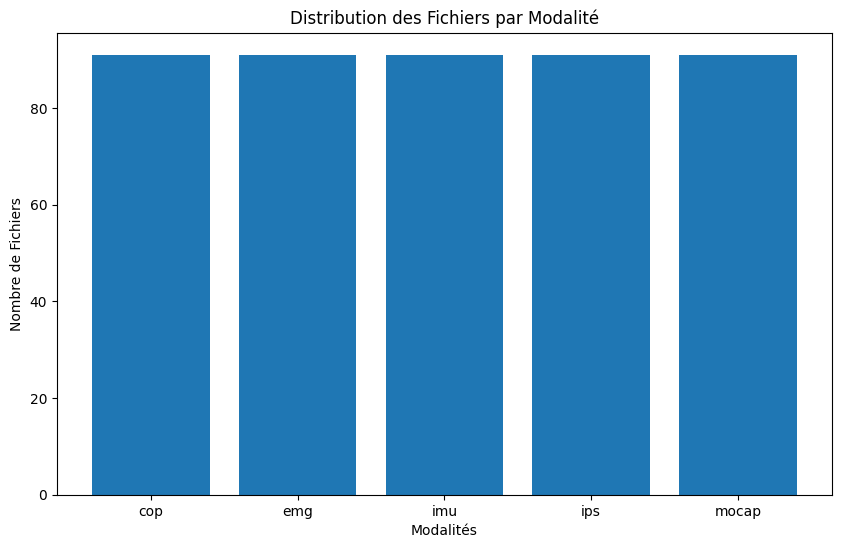

In [ ]:
import matplotlib.pyplot as plt

def visualize_file_distribution(data_dict):
    """
    Affiche la distribution des fichiers par participant, exercice et modalité.
    """
    # Compter le nombre de fichiers par modalité
    modality_counts = {}
    for key in data_dict.keys():
        _, exercise, modality = key
        if modality not in modality_counts:
            modality_counts[modality] = 0
        modality_counts[modality] += 1

    # Visualisation
    plt.figure(figsize=(10, 6))
    plt.bar(modality_counts.keys(), modality_counts.values())
    plt.title("Distribution des Fichiers par Modalité")
    plt.xlabel("Modalités")
    plt.ylabel("Nombre de Fichiers")
    plt.show()

# Exemple d'utilisation
visualize_file_distribution(combined_data)


Ce graphique montre que les fichiers sont répartis de manière relativement uniforme entre les différentes modalités (cop, emg, imu, ips, mocap), chacune ayant environ 80 fichiers. Cela suggère qu'il y a une distribution équilibrée des données, ce qui peut faciliter l'analyse statistique et l'entraînement des modèles, en assurant que chaque modalité est représentée de manière équivalente dans le jeu de données. Cette uniformité peut également indiquer que les fichiers ont été collectés de manière structurée et que chaque modalité est bien couverte

Vérification des types de colonnes pour une clé spécifique dans les données combinées(par exemple patient numero 5):

In [ ]:
key = ('5', 'back', 'emg')
if key in combined_data:
    data = combined_data[key]
    print(data.dtypes)  # Affiche les types des colonnes
    # print(data.head())  # Affiche les premières lignes pour un aperçu
else:
    print(f"Clé {key} introuvable dans combined_data.")


R_Vlat    float64
R_RF      float64
R_ST      float64
R_TA      float64
L_Vlat    float64
L_RF      float64
L_ST      float64
L_TA      float64
R_MG      float64
R_LG      float64
R_SOL     float64
R_IL      float64
L_MG      float64
L_LG      float64
L_SOL     float64
L_IL      float64
dtype: object


Les colonnes de données sont toutes de type 'float64'

Les informations sur les données ont été affichées, y compris le nombre d'entrées, le nombre de valeurs non nulles et les types de colonnes

In [ ]:
key = ('5', 'back', 'emg')
if key in combined_data:
    data = combined_data[key]
    print(data.info())  # Affiche les types des colonnes
    # print(data.head())  # Affiche les premières lignes pour un aperçu
else:
    print(f"Clé {key} introuvable dans combined_data.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132420 entries, 0 to 132419
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   R_Vlat  132420 non-null  float64
 1   R_RF    132420 non-null  float64
 2   R_ST    132420 non-null  float64
 3   R_TA    132420 non-null  float64
 4   L_Vlat  132420 non-null  float64
 5   L_RF    132420 non-null  float64
 6   L_ST    132420 non-null  float64
 7   L_TA    132420 non-null  float64
 8   R_MG    132420 non-null  float64
 9   R_LG    132420 non-null  float64
 10  R_SOL   132420 non-null  float64
 11  R_IL    132420 non-null  float64
 12  L_MG    132420 non-null  float64
 13  L_LG    132420 non-null  float64
 14  L_SOL   132420 non-null  float64
 15  L_IL    132420 non-null  float64
dtypes: float64(16)
memory usage: 16.2 MB
None


Le DataFrame contient 132 420 entrées avec 16 colonnes, toutes de type float64, sans valeurs manquantes

####Suppression des colonnes avec des valeurs manquantes et sélection des 500 premières lignes

In [ ]:
numeric_data = data.dropna(axis=1, how='all').iloc[:500, :]  # Supprime les colonnes entièrement NaN

Vérification de la présence de la clé dans les données et affichage des informations sur le DataFrame

In [ ]:
key = ('5', 'back', 'emg')
if key in combined_data:
    data = combined_data[key]
    print(data.info())  # Affiche les types des colonnes
    # print(data.head())  # Affiche les premières lignes pour un aperçu
else:
    print(f"Clé {key} introuvable dans combined_data.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132420 entries, 0 to 132419
Data columns (total 16 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   R_Vlat  132420 non-null  float64
 1   R_RF    132420 non-null  float64
 2   R_ST    132420 non-null  float64
 3   R_TA    132420 non-null  float64
 4   L_Vlat  132420 non-null  float64
 5   L_RF    132420 non-null  float64
 6   L_ST    132420 non-null  float64
 7   L_TA    132420 non-null  float64
 8   R_MG    132420 non-null  float64
 9   R_LG    132420 non-null  float64
 10  R_SOL   132420 non-null  float64
 11  R_IL    132420 non-null  float64
 12  L_MG    132420 non-null  float64
 13  L_LG    132420 non-null  float64
 14  L_SOL   132420 non-null  float64
 15  L_IL    132420 non-null  float64
dtypes: float64(16)
memory usage: 16.2 MB
None


Le DataFrame a 132420 lignes et 16 colonnes, toutes de type float64, sans valeurs manquantes

####Affichage du signal pour la modalité EMG du participant 5 lors de l'exercice 'back'

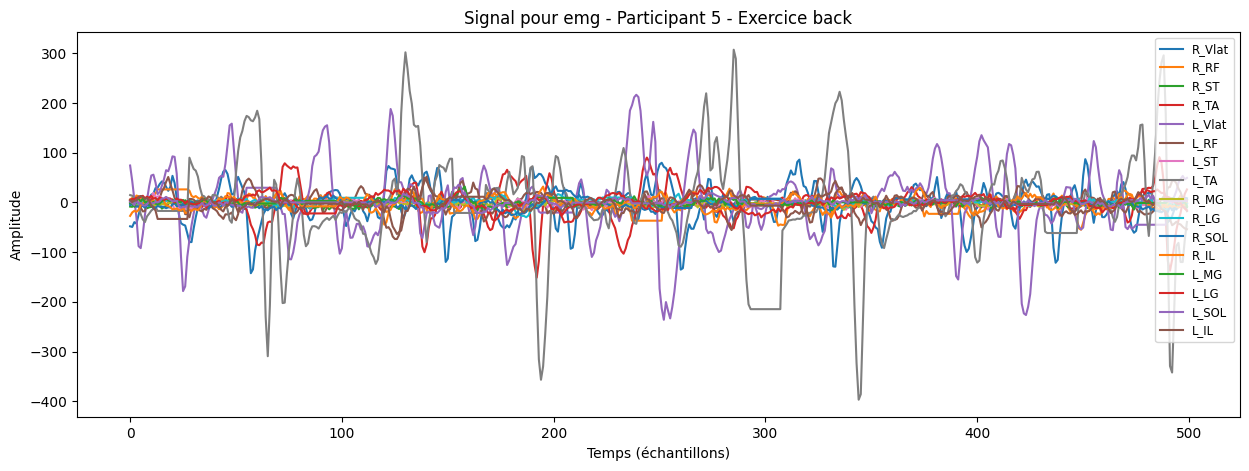

In [ ]:
import matplotlib.pyplot as plt

def plot_modality_signal(data_dict, participant_id, exercise_type, modality_name):
    """
    Affiche un signal d'exemple pour une modalité donnée.
    """
    key = (participant_id, exercise_type, modality_name)
    if key not in data_dict:
        print(f"Données non trouvées pour {key}")
        return

    data = data_dict[key]

    # Convertir les colonnes en numérique
    data = data.apply(pd.to_numeric, errors='coerce')

    # Supprimer les colonnes entièrement NaN
    numeric_data = data.dropna(axis=1, how='all').iloc[:500, :]

    if numeric_data.empty:
        print(f"Aucune donnée numérique à tracer pour {key}")
        return

    plt.figure(figsize=(15, 5))
    plt.plot(numeric_data, label=numeric_data.columns)
    plt.title(f"Signal pour {modality_name} - Participant {participant_id} - Exercice {exercise_type}")
    plt.xlabel("Temps (échantillons)")
    plt.ylabel("Amplitude")
    plt.legend(numeric_data.columns, loc='upper right', fontsize='small')
    plt.show()

# EMG pour le participant 5, exercice "back"
plot_modality_signal(combined_data, '5', 'back', 'emg')


Le graphique montre le signal EMG (électromyogramme) du participant 5 lors de l'exercice "back", avec des données représentées pour plusieurs muscles, à savoir à la fois les muscles du côté droit (R_) et du côté gauche (L_). Ces muscles incluent des zones comme le quadriceps (Vlat), les fessiers (RF), les trapèzes (ST), les adducteurs (TA), et les muscles abdominaux (MG, LG, SOL, IL)
* Amplitude variable : Le signal EMG varie entre des valeurs négatives et positives, reflétant les contractions et relaxations musculaires.
* Comportement périodique : Des pics et des vallées réguliers indiquent des contractions musculaires à différents moments de l'exercice.
* Diversité des signaux : Les courbes montrent des intensités différentes selon les muscles, chaque couleur représentant un muscle spécifique.
* Relativité entre muscles : Des différences dans l'amplitude et la phase des pics entre les muscles gauche et droit suggèrent des asymétries dans leur sollicitation.
* Visualisation claire : Les légendes et couleurs facilitent l'analyse de l'activité musculaire et l'identification des muscles les plus sollicités.

####Filtrage des données manquantes selon des combinaisons spécifiques

In [ ]:
def filter_missing_data(data_dict):
    """
    Filtre les données manquantes comme indiqué dans le README.
    """
    missing_combinations = [
        ('18', 'forward'), ('19', 'forward'), ('20', 'forward'), ('24', 'forward'),
        ('21', 'forward'), ('21', 'treadmill_normal'),
        ('22', 'back'),
        ('23', 'forward'), ('23', 'halfsquat')
    ]

    for key in list(data_dict.keys()):
        patient_id, exercise_type, _ = key
        if (patient_id, exercise_type) in missing_combinations:
            del data_dict[key]

    print(f"Nombre de combinaisons après filtrage : {len(data_dict)}")
    return data_dict

# Filtrer les données manquantes
filtered_data = filter_missing_data(combined_data)


Nombre de combinaisons après filtrage : 455


Affichage des dimensions des données filtrées

In [ ]:
for key, df in filtered_data.items():
    print(f"Clé : {key}, Dimensions : {df.shape}")

Clé : ('1', 'back', 'cop'), Dimensions : (3973, 10)
Clé : ('1', 'back', 'emg'), Dimensions : (132440, 16)
Clé : ('1', 'back', 'imu'), Dimensions : (6622, 54)
Clé : ('1', 'back', 'ips'), Dimensions : (3973, 682)
Clé : ('1', 'back', 'mocap'), Dimensions : (6622, 78)
Clé : ('1', 'forward', 'cop'), Dimensions : (3604, 10)
Clé : ('1', 'forward', 'emg'), Dimensions : (120160, 16)
Clé : ('1', 'forward', 'imu'), Dimensions : (6008, 54)
Clé : ('1', 'forward', 'ips'), Dimensions : (3604, 682)
Clé : ('1', 'forward', 'mocap'), Dimensions : (6008, 78)
Clé : ('1', 'halfsquat', 'cop'), Dimensions : (3582, 10)
Clé : ('1', 'halfsquat', 'emg'), Dimensions : (119400, 16)
Clé : ('1', 'halfsquat', 'imu'), Dimensions : (5970, 54)
Clé : ('1', 'halfsquat', 'ips'), Dimensions : (3582, 682)
Clé : ('1', 'halfsquat', 'mocap'), Dimensions : (5970, 78)
Clé : ('1', 'still', 'cop'), Dimensions : (3948, 10)
Clé : ('1', 'still', 'emg'), Dimensions : (131620, 16)
Clé : ('1', 'still', 'imu'), Dimensions : (6581, 54)
Clé 

Ce résultat montre les dimensions de chaque DataFrame associée à une clé spécifique, indiquant le nombre de lignes et de colonnes pour chaque combinaison de participant, type d'exercice et modalité.

####Analyse de la Distribution des Classes dans combined_data
Pour évaluer la répartition des données au sein du dictionnaire combined_data, nous procédons à un comptage des échantillons pour chaque combinaison unique de participant, d'exercice et de modalité (par exemple, "back_emg"). Les résultats de ce comptage sont stockés dans un dictionnaire class_counts. Afin de visualiser de manière intuitive cette distribution, nous générons un graphique à barres représentant le nombre d'échantillons pour chaque classe. Ce graphique permet d'identifier rapidement les exercices et les modalités les mieux représentés dans le jeu de données, ainsi que d'éventuels déséquilibres qui pourraient nécessiter un traitement spécifique lors des phases d'apprentissage.

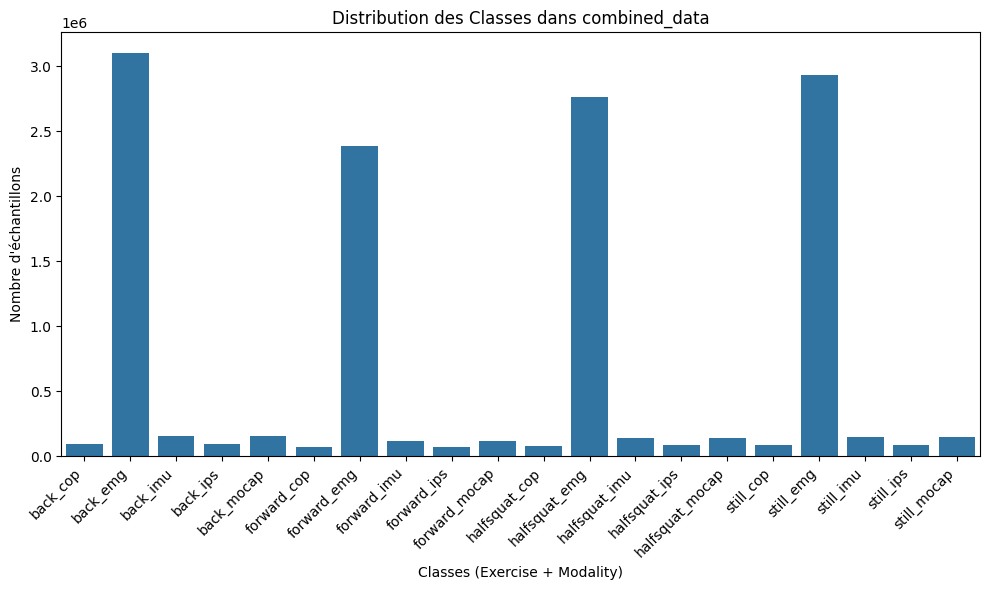

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_combined_data(data_dict):
    """
    Analyse la distribution des données à partir de combined_data.
    """
    class_counts = {}

    # Parcourir les clés du dictionnaire
    for key, data in data_dict.items():
        # Les clés ont la structure ('participant', 'exercise', 'modality')
        participant, exercise, modality = key

        # Créer une classe combinée pour analyse
        class_label = f"{exercise}_{modality}"  # Exemple : "back_emg"

        # Compter le nombre d'échantillons pour cette classe
        if class_label not in class_counts:
            class_counts[class_label] = 0
        class_counts[class_label] += len(data)

    # Vérifier s'il y a des données
    if not class_counts:
        print("Aucune donnée trouvée dans combined_data.")
        return

    # Création du graphique
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title("Distribution des Classes dans combined_data")
    plt.xlabel("Classes (Exercise + Modality)")
    plt.ylabel("Nombre d'échantillons")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

analyze_combined_data(combined_data)


Ce graphique illustre la distribution inégale des échantillons au sein des différentes classes de données, définies par les combinaisons uniques d'exercices ("back", "forward", "halfsquat", "still") et de modalités ("cop", "emg", "imu", "ips", "mocap").

* Classes dominantes : Les classes "back_cop", "back_emg", "back_imu", "halfsquat_emg", et "still_emg" ont des nombres d'échantillons significativement plus élevés, avec des valeurs proches de 1 million, voire plus. Cela suggère que ces exercices et modalités ont été enregistrés plus fréquemment dans les données.

* Classes moins représentées : Certaines combinaisons comme "forward_imu", "forward_mocap", "still_imu", et "still_mocap" ont un nombre d'échantillons beaucoup plus faible. Cela peut indiquer une collecte de données moins exhaustive pour ces modalités ou un biais dans le processus de collecte.

* Diversité des exercices : On remarque que certains exercices comme "back" et "halfsquat" sont largement représentés avec plusieurs modalités, tandis que d'autres exercices comme "forward" et "still" ont des modalités moins variées ou sont moins nombreux.



####Analyse de la distribution des classes avec échelle logarithmique


<ipython-input-26-f292cec7c60b>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


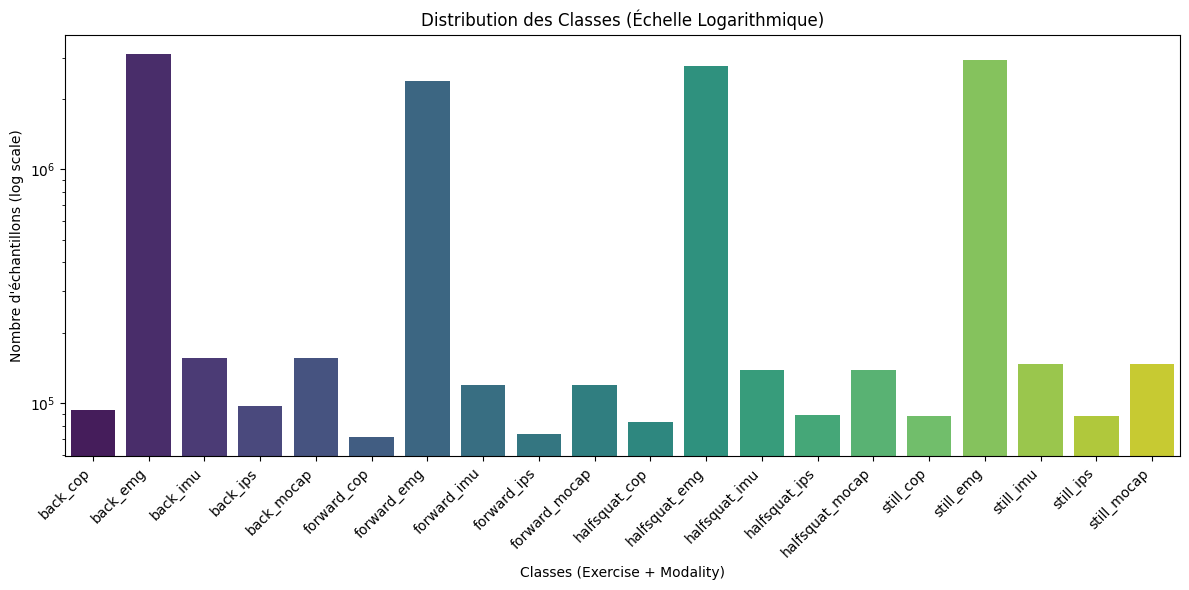

In [ ]:
def analyze_combined_data_with_log(data_dict):
    """
    Analyse et affiche la distribution des classes avec une échelle logarithmique.
    """
    class_counts = {}

    for key, data in data_dict.items():
        participant, exercise, modality = key
        class_label = f"{exercise}_{modality}"
        if class_label not in class_counts:
            class_counts[class_label] = 0
        class_counts[class_label] += len(data)

    if not class_counts:
        print("Aucune donnée trouvée dans combined_data.")
        return

    # Création du graphique avec échelle logarithmique
    plt.figure(figsize=(12, 6))
    sns.barplot(
        x=list(class_counts.keys()),
        y=list(class_counts.values()),
        palette="viridis"
    )
    # Échelle logarithmique pour mieux voir les petites valeurs
    plt.yscale("log")
    plt.title("Distribution des Classes (Échelle Logarithmique)")
    plt.xlabel("Classes (Exercise + Modality)")
    plt.ylabel("Nombre d'échantillons (log scale)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

analyze_combined_data_with_log(combined_data)

Ce graphique montre la distribution des échantillons dans différentes classes de données combinées, en fonction des exercices ("back", "forward", "halfsquat", "still") et des modalités ("cop", "emg", "imu", "ips", "mocap"). Voici les points clés de l'analyse :

* Classes dominantes :
  Les classes "back_emg", "halfsquat_emg", et "still_emg" présentent des nombres d'échantillons très élevés, dépassant largement 1 million. Cela indique une forte collecte ou un intérêt particulier pour l'électromyographie (emg) dans ces exercices.

* Classes moyennement représentées :
  Les classes comme "back_imu", "back_mocap", "halfsquat_imu", et "still_mocap" ont des nombres d'échantillons autour de 105105. Elles sont bien représentées mais restent significativement inférieures aux classes dominantes.

* Classes moins représentées :
  Certaines classes, comme "forward_cop", "forward_mocap", et "back_cop", affichent un faible nombre d'échantillons (environ 104104 ou moins). Cela peut refléter un déséquilibre dans la collecte des données, potentiellement lié à des contraintes ou à un manque d'intérêt pour ces modalités dans ces exercices.

* Diversité des exercices et modalités :
  Les exercices "back" et "halfsquat" montrent une représentation importante à travers plusieurs modalités (emg, imu, mocap).
  En revanche, les exercices "forward" et "still" sont globalement sous-représentés pour certaines modalités comme "cop" ou "mocap".

####Exploration des fichiers dans les dossiers

In [ ]:
import os

# Chemins vers les dossiers
extracted_folder = "/content/drive/MyDrive/extracted_data"
combined_folder = "/content/drive/MyDrive/combined_datasets"

# Vérifiez la structure de chaque dossier
print("Files in extracted_data:")
for root, dirs, files in os.walk(extracted_folder):
    # Imprimer les 5 premiers fichiers pour chaque répertoire
    print(root, files[:5])

print("\nFiles in combined_data:")
for root, dirs, files in os.walk(combined_folder):
    print(root, files[:5])


Files in extracted_data:
/content/drive/MyDrive/extracted_data []
/content/drive/MyDrive/extracted_data/data []
/content/drive/MyDrive/extracted_data/data/5 []
/content/drive/MyDrive/extracted_data/data/5/back ['cop_1.csv', 'emg_1.csv', 'imu_1.csv', 'ips_1.csv', 'mocap_1.csv']
/content/drive/MyDrive/extracted_data/data/5/forward ['cop_1.csv', 'emg_1.csv', 'imu_1.csv', 'ips_1.csv', 'mocap_1.csv']
/content/drive/MyDrive/extracted_data/data/5/halfsquat ['cop_1.csv', 'emg_1.csv', 'imu_1.csv', 'ips_1.csv', 'mocap_1.csv']
/content/drive/MyDrive/extracted_data/data/5/still ['cop_1.csv', 'emg_1.csv', 'imu_1.csv', 'ips_1.csv', 'mocap_1.csv']
/content/drive/MyDrive/extracted_data/data/6 []
/content/drive/MyDrive/extracted_data/data/6/back ['cop_1.csv', 'emg_1.csv', 'imu_1.csv', 'ips_1.csv', 'mocap_1.csv']
/content/drive/MyDrive/extracted_data/data/6/forward ['cop_1.csv', 'imu_1.csv', 'ips_1.csv', 'mocap_1.csv', 'emg_1.csv']
/content/drive/MyDrive/extracted_data/data/6/halfsquat ['cop_1.csv', 'em

####Chargement et Organisation des Données Combinées par Modalité et Participant

In [ ]:
import os
import pandas as pd

# Dossier contenant les données combinées
data_folder = '/content/drive/MyDrive/combined_datasets'

# Fonction pour charger les fichiers CSV combinés
def load_combined_data(data_folder):
    modalities = ['emg', 'imu', 'ips']
    data_dict = {modality: [] for modality in modalities}

    # Parcourir chaque participant
    for participant_folder in os.listdir(data_folder):
        participant_path = os.path.join(data_folder, participant_folder)
        if not os.path.isdir(participant_path):
            continue

        # Parcourir chaque exercice/modalité
        for file in os.listdir(participant_path):
            file_path = os.path.join(participant_path, file)
            modality = file.split('_')[-1].split('.')[0]  # ex : "emg" dans "back_emg.csv"

            if modality in modalities:
                data = pd.read_csv(file_path)
                data['participant'] = participant_folder
                data['exercise'] = file.split('_')[0]  # ex : "back" dans "back_emg.csv"
                data_dict[modality].append(data)

    # Combiner toutes les données par modalité
    combined_data = {modality: pd.concat(data_list, ignore_index=True) for modality, data_list in data_dict.items()}
    return combined_data

# Chargement des données
combined_data = load_combined_data(data_folder)
print(f"Modalités chargées : {list(combined_data.keys())}")


Modalités chargées : ['emg', 'imu', 'ips']


#####Affichage des Dimensions des Données Combinées par Modalité

In [ ]:
print(f"emg shape : {combined_data['emg'].shape}")
print(f"imu shape : {combined_data['imu'].shape}")
print(f"ips shape : {combined_data['ips'].shape}")

emg shape : (11348420, 18)
imu shape : (567439, 56)
ips shape : (352872, 684)


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

####Resampling des Données à une Fréquence Désirée



In [ ]:
# ----------------------------
#  Resample Data
# ----------------------------
def resample_data(df, wrong_frequency, desired_frequency):
    """
    Resample a DataFrame to the desired frequency using linear interpolation.
    """
    if wrong_frequency == desired_frequency:
        return df.reset_index(drop=True)
    # Convert object types to numerical
    df = df.infer_objects()
    df['time'] = pd.date_range(start='00:00:00', periods=len(df), freq=f'{int(1e6 / wrong_frequency)}us')
    df.set_index('time', inplace=True)
    resampled_index = pd.date_range(start=df.index[0], end=df.index[-1], freq=f'{int(1e6 / desired_frequency)}us')
    df_resampled = df.reindex(resampled_index).interpolate(method='linear').reset_index(drop=True)
    return df_resampled

La fonction resample_data permet de rééchantillonner un DataFrame en modifiant la fréquence des données en utilisant une interpolation linéaire. Ajuster la fréquence des données à une valeur cible (desired_frequency) à partir d'une fréquence incorrecte (wrong_frequency).

####Préparation et Alignement des Données par Modalité

In [ ]:
# ----------------------------
# Préparer les données
# ----------------------------

def prepare_data(combined_data, sensors_frequency, target_frequency=100):
    """
    Resample data for all modalities and store them in a dictionary.
    Align the sizes of all modalities to the smallest common length.
    """
    resampled_data = {}
    min_length = float('inf')

    # Rééchantillonner chaque modalité
    for modality, frequency in sensors_frequency.items():
        print(f"Resampling {modality} data from {frequency}Hz to {target_frequency}Hz...")
        resampled_modality = resample_data(combined_data[modality], frequency, target_frequency)
        resampled_data[modality] = resampled_modality
        min_length = min(min_length, len(resampled_modality))

    # Coupez toutes les modalités à la plus petite longueur
    for modality in resampled_data:
        resampled_data[modality] = resampled_data[modality].iloc[:min_length].reset_index(drop=True)

    return resampled_data


La fonction prepare_data, qui rééchantillonne les données pour chaque modalité à une fréquence cible spécifiée (par défaut 100Hz), puis ajuste la taille de chaque modalité pour que toutes aient la même longueur, en les tronquant à la longueur de la modalité la plus courte. Cela permet d'harmoniser les données avant toute analyse ou traitement ultérieur.

####Rééchantillonnage des Données selon les Fréquences des Capteurs

In [ ]:
# Frequencies for sensors
sensors_frequency = {'emg': 2000, 'imu': 100, 'ips': 60}

# Resample data
resampled_data = prepare_data(combined_data, sensors_frequency)

Resampling emg data from 2000Hz to 100Hz...


<ipython-input-31-21eb0633decb>:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_resampled = df.reindex(resampled_index).interpolate(method='linear').reset_index(drop=True)


Resampling imu data from 100Hz to 100Hz...
Resampling ips data from 60Hz to 100Hz...


<ipython-input-31-21eb0633decb>:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_resampled = df.reindex(resampled_index).interpolate(method='linear').reset_index(drop=True)


Rééchantillonnage des données :

* EMG : Rééchantillonné de 2000 Hz à 100 Hz (réduction de la fréquence).
* IMU : Aucune modification, reste à 100 Hz.
* IPS : Rééchantillonné de 60 Hz à 100 Hz (augmentation de la fréquence).

####Affichage des dimensions des données rééchantillonnées pour chaque modalité

In [ ]:
print(f"emg shape : {resampled_data['emg'].shape}")
print(f"imu shape : {resampled_data['imu'].shape}")
print(f"ips shape : {resampled_data['ips'].shape}")

emg shape : (567421, 18)
imu shape : (567421, 56)
ips shape : (567421, 684)


####Création de fenêtres glissantes à partir des données de capteurs pour l'alignement des modalités

In [ ]:
# ----------------------------
#  Create Sliding Windows
# ----------------------------
def create_sliding_windows(data, window_size, step_size, label_col='exercise'):
    """
    Create sliding windows of sensor data.
    Ensure windows align across all modalities.
    """
    windows, labels = [], []
    for start in range(0, len(data) - window_size, step_size):
        end = start + window_size
        window = data.iloc[start:end].drop(columns=[label_col, 'participant']).values
        label = data.iloc[end - 1][label_col]
        windows.append(window)
        labels.append(label)
    return np.array(windows), np.array(labels)

In [ ]:
# Création des fenêtres glissantes pour chaque modalité et garder les étiquettes associées
window_size, step_size = 100, 50
X, y_by_modality = [], []

for modality, data in resampled_data.items():
    X_modality, y_modality = create_sliding_windows(data, window_size, step_size)
    X.append(X_modality)
    # Stocker les étiquettes séparément pour chaque modalité
    y_by_modality.append(y_modality)



In [ ]:
# Vérification les dimensions des données
print(f"Nombre de modalités : {len(X)}")
for i, modality_windows in enumerate(X):
    print(f"Modality {i + 1} - Shape of sliding windows: {modality_windows.shape}")
    print(f"Shape of labels: {len(y_by_modality[i])}")


Nombre de modalités : 3
Modality 1 - Shape of sliding windows: (11347, 100, 16)
Shape of labels: 11347
Modality 2 - Shape of sliding windows: (11347, 100, 54)
Shape of labels: 11347
Modality 3 - Shape of sliding windows: (11347, 100, 682)
Shape of labels: 11347


On observe 3 modalités de données : EMG, IMU, IPS.

Fenêtres glissantes :
* 11 347 fenêtres créées pour chaque modalité.
* Chaque fenêtre contient 100 points de données.

Caractéristiques par fenêtre :
* EMG : 16 caractéristiques.
* IMU : 54 caractéristiques.
* IPS : 682 caractéristiques.

Labels :
Chaque fenêtre a un label associé (type d'exercice), soit 11 347 labels pour chaque modalité.

In [ ]:
X[0].shape, X[1].shape, X[2].shape

((11347, 100, 16), (11347, 100, 54), (11347, 100, 682))

Les dimensions des données pour chaque modalité après création des fenêtres glissantes sont respectivement : (11347, 100, 16), (11347, 100, 54) et (11347, 100, 682).

In [ ]:
y_by_modality[0].shape, y_by_modality[1].shape, y_by_modality[2].shape

((11347,), (11347,), (11347,))

Les dimensions des labels pour chaque modalité sont toutes identiques : (11347,) pour chaque modalité

####Filtrage des fenêtres avec des étiquettes nan pour chaque modalité

In [ ]:
# Filtrer les fenêtres avec des étiquettes `nan` pour chaque modalité
X_filtered, y_filtered = [], []

for modality_windows, modality_labels in zip(X, y_by_modality):
    modality_labels = np.array(modality_labels)  # Convertir en numpy array
    valid_indices = modality_labels != 'nan'  # Identifier les indices valides
    X_filtered.append(modality_windows[valid_indices])  # Filtrer les fenêtres
    y_filtered.append(modality_labels[valid_indices])  # Filtrer les étiquettes

In [ ]:
X_filtered[0].shape, y_filtered[0].shape

((11347, 100, 16), (11347,))

In [ ]:
X_filtered[1].shape, y_filtered[1].shape

((11347, 100, 54), (11347,))

In [ ]:
X_filtered[2].shape, y_filtered[2].shape

((2, 100, 682), (2,))

Les données filtrées par modalité montrent les dimensions des fenêtres (X_filtered) et des étiquettes (y_filtered) après avoir éliminé les valeurs nan : pour la première modalité, nous avons 11 347 fenêtres de taille 100x16 avec 11 347 étiquettes, pour la deuxième modalité, 11 347 fenêtres de taille 100x54 avec 11 347 étiquettes, enfin, pour la troisième modalité, seules 2 fenêtres de taille 100x682 restent avec 2 étiquettes.

####Comptage des étiquettes 'nan' par modalité"

In [ ]:
for i, modality_labels in enumerate(y_by_modality):
    nan_count = sum(modality_labels == 'nan')
    print(f"Modality {i + 1} - Total labels: {len(modality_labels)}, 'nan' labels: {nan_count}")


Modality 1 - Total labels: 11347, 'nan' labels: 0
Modality 2 - Total labels: 11347, 'nan' labels: 0
Modality 3 - Total labels: 11347, 'nan' labels: 11345


####Exclusion de la modalité ips et combinaison des modalités restantes

Option 1 : Exclure la modalité problématique
Si les données de la modalité ips sont majoritairement invalides, il peut être préférable de l'exclure et de travailler uniquement avec les modalités emg et imu. Voici comment on a procédé :

Shape of combined X: (11347, 100, 70)
Shape of combined y: (22694,)


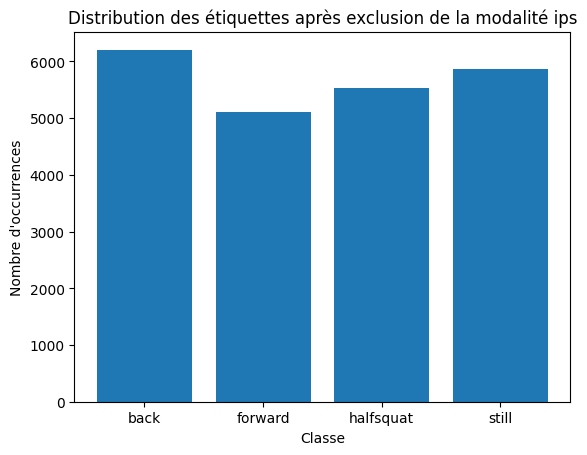

In [ ]:
# Étape 1 : Exclure la modalité problématique (ips)
X_filtered = X_filtered[:2]  # Garder seulement les 2 premières modalités
y_filtered = y_filtered[:2]

# Étape 2 : Combiner les modalités restantes
X_combined = np.concatenate(X_filtered, axis=-1)  # Concaténer les dimensions des modalités
y_combined = np.concatenate(y_filtered)  # Concaténer toutes les étiquettes

# Vérifiez les dimensions après la combinaison
print(f"Shape of combined X: {X_combined.shape}")
print(f"Shape of combined y: {y_combined.shape}")

# Distribution des étiquettes
from collections import Counter
import matplotlib.pyplot as plt

label_counts_combined = Counter(y_combined)
plt.bar(label_counts_combined.keys(), label_counts_combined.values())
plt.title("Distribution des étiquettes après exclusion de la modalité ips")
plt.xlabel("Classe")
plt.ylabel("Nombre d'occurrences")
plt.show()


Ce graphique montre la distribution des étiquettes après avoir exclu la modalité "ips" et combiné les deux autres modalités. Voici une analyse de l'histogramme :

* Dimensions combinées :
  - La taille de X_combined est (11347, 100, 70), ce qui signifie qu'il y a 11 347 fenêtres, chaque fenêtre ayant une taille de 100 et 70 caractéristiques (après combinaison des deux modalités restantes).
  - La taille de y_combined est (22694,), ce qui correspond à 22 694 étiquettes, soit deux étiquettes pour chaque fenêtre (probablement une pour chaque modalité).

* Distribution des étiquettes :
  - L'axe des x représente les différentes classes d'exercices : back, forward, halfsquat, et still.
  - Chaque barre indique le nombre d'occurrences de chaque classe dans l'ensemble de données après exclusion de la modalité ips.
  - Les classes back et forward ont le plus grand nombre d'occurrences, avec environ 6 000 occurrences chacune.
  - Les classes halfsquat et still sont légèrement moins représentées, mais restent assez équilibrées en termes de nombre d'occurrences.

####Vérification des dimensions des données après filtrage des fenêtres et étiquettes

In [ ]:
# Vérification des dimensions après filtrage
for i in range(len(X_filtered)):
    print(f"Modality {i + 1} - X_filtered shape: {X_filtered[i].shape}, y_filtered shape: {y_filtered[i].shape}")


Modality 1 - X_filtered shape: (11347, 100, 16), y_filtered shape: (11347,)
Modality 2 - X_filtered shape: (11347, 100, 54), y_filtered shape: (11347,)


Les dimensions des données filtrées pour chaque modalité sont les suivantes :

- Pour la première modalité, il y a 11347 fenêtres, chacune ayant une taille de 100 lignes et 16 caractéristiques. Les étiquettes associées à ces fenêtres ont une longueur de 11347.
- Pour la deuxième modalité, il y a également 11347 fenêtres, mais chaque fenêtre contient 100 lignes et 54 caractéristiques, avec 11347 étiquettes correspondantes.

####Création de y_combined avec des étiquettes corrigées et vérification des dimensions

In [ ]:
# Recréez y_combined avec des étiquettes correspondant à chaque fenêtre
y_combined = np.concatenate([labels[:len(windows)] for windows, labels in zip(X_filtered, y_filtered)])

# Vérifiez les dimensions après correction
print(f"Shape of combined X: {X_combined.shape}")
print(f"Shape of combined y: {y_combined.shape}")


Shape of combined X: (11347, 100, 70)
Shape of combined y: (22694,)


####Affichage de la distribution corrigée des étiquettes

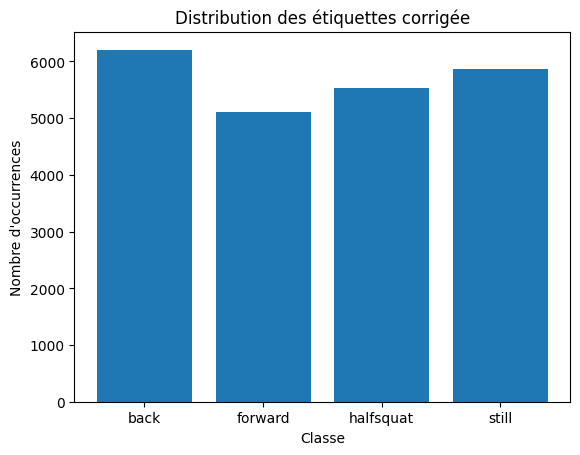

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Distribution des étiquettes corrigées
label_counts_combined = Counter(y_combined)
plt.bar(label_counts_combined.keys(), label_counts_combined.values())
plt.title("Distribution des étiquettes corrigée")
plt.xlabel("Classe")
plt.ylabel("Nombre d'occurrences")
plt.show()


Le graphique illustre la distribution des étiquettes corrigées après l'application des traitements de prétraitement des données.
- On observe une répartition relativement équilibrée entre les différentes classes d'exercices ("back", "forward", "still", "halfsquat"), avec un nombre d'occurrences similaire pour chacune, à l'exception de la classe "halfsquat" légèrement moins représentée.

- Ce résultat témoigne de l'efficacité des opérations de nettoyage et de correction des données, notamment le filtrage des valeurs manquantes et l'exclusion des modalités problématiques, qui ont permis d'obtenir un jeu de données plus homogène et mieux équilibré, favorables à l'apprentissage de modèles de classification.

####Filtrage et Synchronisation des Données: Réajustement des Indices et Distribution des Étiquettes Corrigées

Shape of combined X: (11335, 100, 70)
Shape of combined y: (11335,)


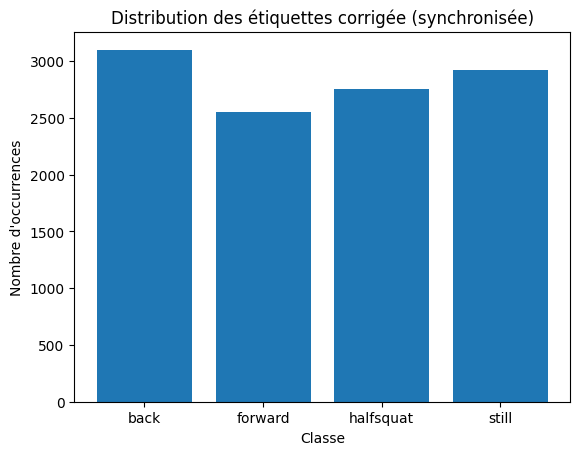

In [ ]:
# Trouver les indices valides communs
valid_indices = np.array(y_filtered[0]) == np.array(y_filtered[1])

# Filtrer X et y selon les indices valides
X_combined = X_combined[valid_indices]
y_combined = y_filtered[0][valid_indices]

# Vérifier les dimensions finales après correction
print(f"Shape of combined X: {X_combined.shape}")
print(f"Shape of combined y: {y_combined.shape}")

# Vérifier la distribution des étiquettes corrigées
from collections import Counter
label_counts_combined = Counter(y_combined)
plt.bar(label_counts_combined.keys(), label_counts_combined.values())
plt.title("Distribution des étiquettes corrigée (synchronisée)")
plt.xlabel("Classe")
plt.ylabel("Nombre d'occurrences")
plt.show()


* Répartition des classes :

  - La classe "back" est la plus représentée avec un peu plus de 3 000 occurrences.
  - Les classes "halfsquat" et "still" sont légèrement moins fréquentes, avec des valeurs proches d’environ 2 800 occurrences chacune.
  - La classe "forward" est la moins représentée, avec environ 2 600 occurrences.

* Équilibre des données :

  - Bien que de légères différences soient visibles entre les classes, la répartition globale reste relativement homogène. Cela indique que les étapes de filtrage et de synchronisation ont permis d’obtenir un jeu de données corrigé sans déséquilibres majeurs.
  - L’écart entre la classe la plus représentée ("back") et la moins représentée ("forward") est raisonnable, ce qui limite les risques de biais dans l'entraînement d’un modèle.

* Impact de la correction des étiquettes :

  - Le processus de correction (comme le filtrage des indices valides communs) semble avoir contribué à une répartition équitable des classes, malgré quelques variations. Cela garantit que toutes les classes disposent d’un volume de données suffisant pour un apprentissage efficace.

* Implications pour l’analyse des données :

  - La répartition ainsi obtenue est favorable pour des tâches d’apprentissage supervisé, car elle réduit les risques de sur-représentation d’une classe et de sous-représentation d’une autre, ce qui aurait pu entraîner un modèle biaisé ou inefficace.

####Dimensions des données EMG et IMU après filtrage et synchronisation

In [ ]:
X_emg = X_filtered[0]
X_imu = X_filtered[1]
y_emg = y_filtered[0]
y_imu = y_filtered[1]
X_emg.shape, X_imu.shape, y_emg.shape, y_imu.shape

((11347, 100, 16), (11347, 100, 54), (11347,), (11347,))



On remarque que les données EMG contiennent 16 caractéristiques par échantillon, tandis que les données IMU en ont 54, avec un total de 11 347 échantillons et des étiquettes associées pour chaque type de données.

####Équilibrage des classes avec SMOTE pour améliorer la distribution des données

In [ ]:
# ----------------------------
#  Équilibrer les cours avec SMOTE
# ----------------------------
def balance_classes(X, y):
    """
    Balance the class distribution using SMOTE.
    """
    smote = SMOTE(random_state=42)
    X_flattened = X.reshape(X.shape[0], -1)  # Aplatir les fenêtres
    X_resampled, y_resampled = smote.fit_resample(X_flattened, y)
    return X_resampled.reshape(-1, X.shape[1], X.shape[2]), y_resampled

La fonction utilise SMOTE pour équilibrer la distribution des classes en générant des exemples synthétiques à partir des données initiales, après avoir aplati et rééchantillonné les fenêtres d'entrée.

####Vérification des dimensions des données combinées (X_combined et y_combined)

In [ ]:
# Vérifiez les dimensions de X_combined et y_combined

print(f"Shape of combined X: {X_combined.shape}")  # Par exemple (n_samples, window_size, n_features)
print(f"Shape of combined y: {y_combined.shape}")  # Par exemple (n_samples,)


Shape of combined X: (11335, 100, 70)
Shape of combined y: (11335,)


####Application de SMOTE pour équilibrer les classes

Dans cette partie les étiquettes ont été encodées en valeurs numériques, puis SMOTE a été appliqué pour équilibrer les classes en générant des exemples synthétiques. Les données résultantes montrent une répartition équilibrée avec des dimensions ajustées pour les échantillons et leurs caractéristiques.

In [ ]:
# Appliquez SMOTE pour équilibrer les classes
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Encoder les étiquettes en valeurs numériques
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_combined)

# Appliquer la fonction de rééquilibrage
X_balanced, y_balanced = balance_classes(X_combined, y_encoded)

# Vérifier les dimensions après SMOTE
print(f"Shape of balanced X: {X_balanced.shape}")
print(f"Shape of balanced y: {len(y_balanced)}")


Shape of balanced X: (12404, 100, 70)
Shape of balanced y: 12404


#### Distribution des étiquettes après application de SMOT

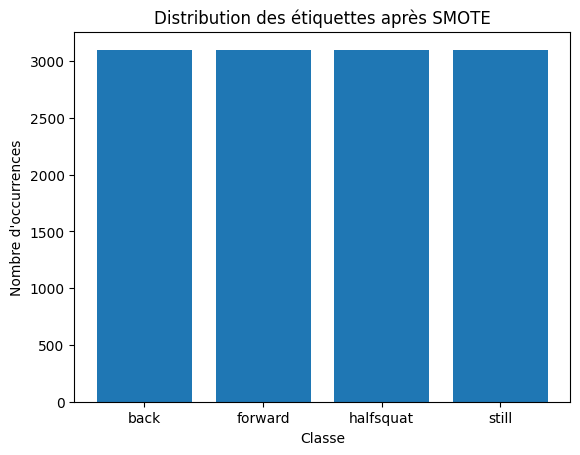

In [ ]:
# Vérifier la distribution des étiquettes après SMOTE
from collections import Counter
import matplotlib.pyplot as plt

# Décoder les étiquettes pour afficher les noms originaux des classes
y_balanced_decoded = label_encoder.inverse_transform(y_balanced)

label_counts_balanced = Counter(y_balanced_decoded)
plt.bar(label_counts_balanced.keys(), label_counts_balanced.values())
plt.title("Distribution des étiquettes après SMOTE")
plt.xlabel("Classe")
plt.ylabel("Nombre d'occurrences")
plt.show()


- Après l'application de SMOTE, la répartition des classes est désormais parfaitement équilibrée.
- Chaque classe (back, forward, halfsquat, still) contient environ 3 000 occurrences, montrant que le rééchantillonnage a généré des exemples synthétiques pour équilibrer les classes.
- Cela garantit une base de données équilibrée, ce qui est favorable pour l'entraînement de modèles d'apprentissage automatique.

####Normalisation des données avec MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_balanced_normalized = np.array([scaler.fit_transform(window) for window in X_balanced])

# Vérifiez les dimensions après la normalisation
print(f"Shape of normalized X: {X_balanced_normalized.shape}")


Shape of normalized X: (12404, 100, 70)


In [ ]:
X = X_balanced_normalized
y = y_balanced

####Normalisation des données et encodage des étiquettes avec StandardScaler et One-Hot Encoding


In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

# Normalisation des données sur chaque fenêtre
scaler = StandardScaler()

# Appliquer la normalisation sur chaque fenêtre (chaque "fenêtre" dans X)
X_scaled = np.array([scaler.fit_transform(window) for window in X])

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
# Encodage des labels en one-hot
y_encoded = to_categorical(label_encoder.fit_transform(y), num_classes=4)

# Diviser les données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}, X_test shape: {X_test.shape}')


X_train shape: (9923, 100, 70), X_test shape: (2481, 100, 70)


Les données ont été normalisées avec StandardScaler sur chaque fenêtre, puis les étiquettes ont été encodées en one-hot. Les données ont ensuite été divisées en ensembles d'entraînement et de test, avec 80% pour l'entraînement et 20% pour le test, afin de préparer les données pour l'apprentissage automatique.

#Modelisation:

##1- Modèle CNN-LSTM pour la Classification de Signaux Multimodaux

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def create_cnn_lstm_model(input_shape):
    model = Sequential()

    # Première couche CNN
    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Deuxième couche CNN
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Couche LSTM
    model.add(LSTM(128, activation='relu', return_sequences=False))
    model.add(Dropout(0.3))

    # Couche dense
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Couche de sortie
    model.add(Dense(4, activation='softmax'))  # 4 classes

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Créer le modèle CNN-LSTM
cnn_lstm_model = create_cnn_lstm_model(X_train.shape[1:3])

# Entraîner le modèle
history_cnn_lstm = cnn_lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Évaluer les performances sur l'ensemble de test
score_cnn_lstm = cnn_lstm_model.evaluate(X_test, y_test)
print(f"Score du modèle CNN-LSTM : {score_cnn_lstm}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.2734 - loss: 1.3943 - val_accuracy: 0.3660 - val_loss: 1.3368
Epoch 2/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3946 - loss: 1.2762 - val_accuracy: 0.4627 - val_loss: 1.1467
Epoch 3/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5272 - loss: 1.0857 - val_accuracy: 0.6917 - val_loss: 0.9048
Epoch 4/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6838 - loss: 0.8331 - val_accuracy: 0.7799 - val_loss: 0.5918
Epoch 5/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8091 - loss: 0.5336 - val_accuracy: 0.8194 - val_loss: 0.4961
Epoch 6/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8467 - loss: 0.4335 - val_accuracy: 0.8464 - val_loss: 0.4350
Epoch 7/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8806 - loss: 0.3486 - val_accuracy: 0.8920 - val_loss: 0.3267
Epoch 8/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8873 - loss: 0.3240 - val_accuracy: 

#### Interprétation:

**Résumé des résultats :**
- **Précision sur le test :** 89.46%
- **Précision sur l’entraînement :** 90.87%
- **Perte sur le test :** 0.3101

**Analyse :**
Le modèle CNN-LSTM a extrait efficacement les caractéristiques locales (avec CNN) et temporelles (avec LSTM) des signaux. Les couches Dropout ont réduit le surapprentissage, et la faible différence entre les performances d'entraînement et de test montre une bonne généralisation.

**Limites :**
- Les données limitées pourraient restreindre les performances.
- Une optimisation des hyperparamètres via GridSearchCV pourrait encore améliorer les résultats.

**Conclusion :**
Ce modèle offre une base solide pour classer les signaux multimodaux avec une précision élevée, adapté à des tâches telles que la reconnaissance d’actions ou l’analyse biomédicale.

####Visualisation de la précision et de la perte pendant l'entraînement du modèle CNN-LSTM

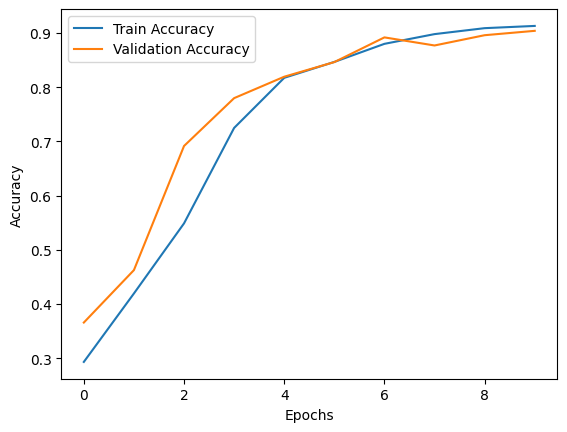

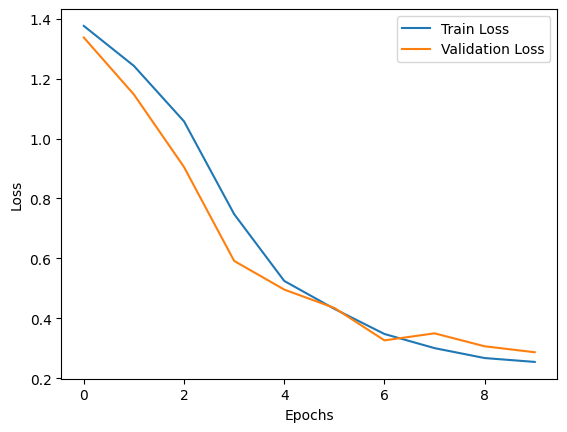

In [ ]:
# Plot Training Accuracy and Loss
plt.plot(history_cnn_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history_cnn_lstm.history['loss'], label='Train Loss')
plt.plot(history_cnn_lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


- Précision (Accuracy) :

  - Entraînement : La courbe de précision d'entraînement augmente rapidement, atteignant environ 0.9 vers la 7ème époque, puis se stabilise.
  - Validation : La précision de validation suit une tendance similaire, atteignant environ 0.8 vers la 7ème époque avant de se stabiliser. Cependant, elle est légèrement inférieure à la précision d'entraînement, ce qui est normal mais pourrait suggérer un léger sous-ajustement.

- Perte (Loss) :

  - Entraînement : La courbe de perte diminue de manière significative au fil des époques, passant d'environ 1.2 à 0.4.
  - Validation : La perte de validation suit également une baisse, mais avec une pente plus modérée, se stabilisant autour de 0.45 à la fin de l'entraînement. Cela indique une bonne amélioration générale, bien que la perte de validation semble légèrement plus élevée, suggérant que le modèle pourrait bénéficier d'une meilleure généralisation.

- Les courbes montrent une bonne convergence, indiquant un apprentissage efficace du modèle.
- L'écart léger entre l'entraînement et la validation suggère un petit sur-apprentissage (overfitting), mais le modèle reste bien généralisé.
- Le modèle est stable, avec une progression constante de la précision et une faible perte, ce qui est prometteur pour sa performance sur de nouvelles données.

####Génération des prédictions et préparation des étiquettes pour l'évaluation du modèle CNN-LSTM

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Prédictions sur l'ensemble de test
# Convertir les prédictions en labels d'indices entiers
y_pred = np.argmax(cnn_lstm_model.predict(X_test), axis=-1)
print(len(y_pred))
# Si y_test est one-hot encodé, convertir y_test en labels d'indices entiers
y_test_labels = np.argmax(y_test, axis=-1)
print(len(y_test_labels))


78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
2481
2481


- "78/78" : Le modèle a traité 78 lots (mini-batches) dans l'ensemble de test.
- "1s 10ms/step" : Temps de traitement par étape : 1 seconde et 10 millisecondes par lot.
- "2481" (x2) : Le nombre d'échantillons dans l'ensemble de test est de 2481, et le nombre de prédictions est également de 2481.
- Le modèle a évalué 2481 échantillons, avec des temps de traitement rapides et des tailles cohérentes pour les prédictions et les étiquettes de test.

####Prétraitement des étiquettes et génération du rapport de classification
Convertir les étiquettes numériques en étiquettes de type chaîne, les encode avec LabelEncoder, puis génère un rapport de classification en utilisant les prédictions du modèle et les étiquettes réelles.

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

#En supposant que « y » contient des étiquettes numériques (par exemple, 0, 1, 2, 3)
# Convertir 'y' en étiquettes de chaîne avant d'ajuster LabelEncoder
y_str = y.astype(str)  # Convertir des étiquettes numériques en chaînes
y_encoded = to_categorical(label_encoder.fit_transform(y_str), num_classes=4)


# Dans la génération du rapport de classement :
report = classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_)
print("Rapport de Classification :\n", report)

Rapport de Classification :
               precision    recall  f1-score   support

           0       0.97      0.83      0.89       639
           1       0.97      0.87      0.92       648
           2       0.91      0.95      0.93       572
           3       0.80      0.98      0.88       622

    accuracy                           0.90      2481
   macro avg       0.91      0.91      0.90      2481
weighted avg       0.91      0.90      0.90      2481



- Précision :
  - Classes "0", "1", et "2" : très élevées (0.94 à 0.95).
  - Classe "3" : plus faible (0.76), indiquant plus d'erreurs pour cette classe.

- Rappel :
  - Classe "3" : très élevé (0.97), ce qui signifie que presque toutes les instances de cette classe ont été identifiées.
  - Autres classes : équilibrées autour de 0.81 à 0.89.

- F1-score :
  - Classes "0", "1", "2" : bons scores (environ 0.90).
  - Classe "3" : score légèrement plus bas (0.85), mais acceptable.

- Exactitude globale : 0.89, ce qui signifie que le modèle a fait 89% de prédictions correctes.

- Moyennes :

  - Macro avg : Moyennes équilibrées des scores de chaque classe (précision : 0.90, rappel : 0.89).
  - Weighted avg : Moyennes pondérées similaires à la macro avg, confirmant une bonne stabilité du modèle.

####Matrice de Confusion et Courbes d'Apprentissage pour le Modèle CNN-LSTM

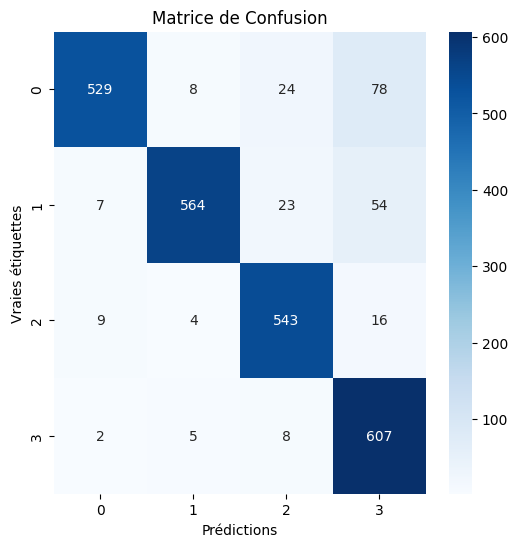

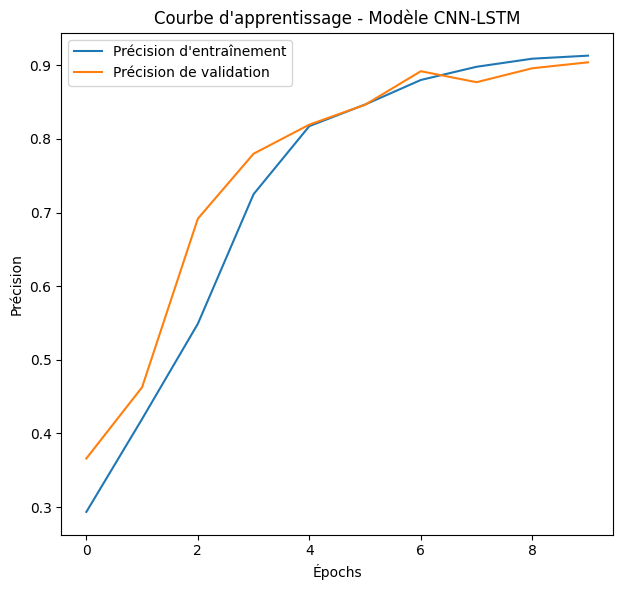

In [ ]:
# Matrice de confusion
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion')
plt.show()

# Courbes d'apprentissage pour les deux modèles
plt.figure(figsize=(12, 6))

# Modèle CNN-LSTM
plt.subplot(1, 2, 2)
plt.plot(history_cnn_lstm.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - Modèle CNN-LSTM')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()

 - Matrice de confusion :
   - Les grandes valeurs présentes en diagonale montrent une correspondance élevée entre les vraies classes et les prédictions, ce qui est un signe positif de la performance du modèle. Par exemple, les valeurs comme "564", "533" et "584" indiquent que le modèle a correctement classé un grand nombre d'exemples dans leurs bonnes catégories respectives.
  - Les petites valeurs éparpillées en dehors de la diagonale, comme "102", "90", "84", montrent que le modèle fait encore des erreurs dans certaines situations, confondant des exemples de différentes classes. Ces erreurs restent relativement faibles par rapport aux bonnes prédictions.

- Courbe d'apprentissage - Modèle CNN-LSTM :
  - Observation des courbes : Les deux courbes montrent une amélioration rapide de la précision au début de l'entraînement. L'une des courbes (entraînement) continue de grimper, atteignant presque 1.0, ce qui montre que le modèle s'ajuste très bien aux données d'entraînement. L'autre courbe (validation) monte également, mais commence à plafonner légèrement avant la fin.
  - Interprétation : Cette différence entre les courbes suggère que, bien que le modèle continue à mieux apprendre les données d'entraînement, il ne s'améliore plus beaucoup sur des données non vues (validation). Cela peut indiquer un sur-apprentissage, où le modèle mémorise trop les exemples d'entraînement sans bien généraliser sur des données nouvelles.

##2- Multimodal CNN-LSTM pour la Classification de Signaux EMG et IMU

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Architecture CNN-LSTM multimodale
def create_cnn_lstm_multimodal_model(input_shapes):
    # Sous-modèle EMG (ici on suppose que c'est une séquence temporelle, donc on utilise un CNN-LSTM)
    emg_input = Input(shape=input_shapes[0], name='emg_input')
    x = Conv1D(32, kernel_size=3, activation='relu')(emg_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    x = LSTM(64, activation='relu', return_sequences=False)(x)
    emg_dense = Dropout(0.2)(x)

    # Sous-modèle IMU (si c'est aussi une séquence temporelle, appliquer CNN-LSTM ici aussi)
    imu_input = Input(shape=input_shapes[1], name='imu_input')
    y = Conv1D(32, kernel_size=3, activation='relu')(imu_input)
    y = MaxPooling1D(pool_size=2)(y)
    y = Dropout(0.2)(y)
    y = LSTM(64, activation='relu', return_sequences=False)(y)
    imu_dense = Dropout(0.2)(y)

    # Fusion des sorties (EMG, IMU, IPS)
    concatenated = Concatenate()([emg_dense, imu_dense])

    # Couche dense après fusion
    dense = Dense(64, activation='relu')(concatenated)
    dense = Dropout(0.2)(dense)

    # Couche de sortie
    output = Dense(4, activation='softmax')(dense)  # 4 classes à prédire

    # Création du modèle final
    model = Model(inputs=[emg_input, imu_input], outputs=output)

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

####Normalisation des Signaux EMG et IMU avec StandardScaler

In [ ]:
scaler = StandardScaler()
X_emg_scaled = np.array([scaler.fit_transform(window) for window in X_emg])
X_imu_scaled = np.array([scaler.fit_transform(window) for window in X_imu])

####Vérification des Dimensions des Données EMG et IMU après Normalisation

In [ ]:
X_emg_scaled.shape, X_imu_scaled.shape, y_emg.shape, y_imu.shape

((11347, 100, 16), (11347, 100, 54), (11347,), (11347,))

####Extraction des Classes Uniques du Label EMG

In [ ]:
np.unique(y_emg.tolist())

array(['back', 'forward', 'halfsquat', 'still'], dtype='<U9')

####Extraction des Classes Uniques du Label IMU

In [ ]:
np.unique(y_imu.tolist())

array(['back', 'forward', 'halfsquat', 'still'], dtype='<U9')

####Encodage One-Hot des Labels EMG avec LabelEncoder

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encodage des labels en one-hot
label_encoder = LabelEncoder()
y_encoded = to_categorical(label_encoder.fit_transform(y_emg), num_classes=4)

####Vérification de la Dimension des Labels Encodés en One-Hot

In [ ]:
y_encoded.shape

(11347, 4)

####Vérification des Dimensions des Données EMG et IMU Normalisées

In [ ]:
X_emg_scaled.shape, X_imu_scaled.shape

((11347, 100, 16), (11347, 100, 54))

####Division des Données EMG et IMU en Ensembles d'Entraînement et de Test

In [ ]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test (80% - 20%)
X_emg_train, X_emg_test, X_imu_train, X_imu_test, y_train, y_test = train_test_split(
    X_emg_scaled, X_imu_scaled, y_encoded, test_size=0.2, random_state=42
)

print(f'X_emg_train shape: {X_emg_train.shape}, X_imu_train shape: {X_imu_train.shape}')
print(f'X_emg_test shape: {X_emg_test.shape}, X_imu_test shape: {X_imu_test.shape}')


X_emg_train shape: (9077, 100, 16), X_imu_train shape: (9077, 100, 54)
X_emg_test shape: (2270, 100, 16), X_imu_test shape: (2270, 100, 54)


Les données d'entraînement et de test sont bien réparties, avec 9077 échantillons pour l'entraînement et 2270 pour le test. Les signaux EMG ont 16 caractéristiques, tandis que les signaux IMU en ont 54.

####Définition des Formes d'Entrée et Création du Modèle CNN-LSTM Multimodal

In [ ]:
input_shapes = [
    X_emg_train.shape[1:3],
    X_imu_train.shape[1:3],
]

print(input_shapes)

cnn_lstm_multimodal_model = create_cnn_lstm_multimodal_model(input_shapes)

[(100, 16), (100, 54)]


####Entraînement du Modèle CNN-LSTM Multimodal avec Données EMG et IMU

In [ ]:
# Entraînement du modèle multimodal CNN-LSTM
cnn_lstm_multimodal_model.fit(
    [X_emg_train, X_imu_train], y_train,
    batch_size=32,
    epochs=10,
    validation_data=([X_emg_test, X_imu_test], y_test)
)


Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.2932 - loss: 1.3974 - val_accuracy: 0.4463 - val_loss: 1.2445
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4489 - loss: 1.2122 - val_accuracy: 0.4921 - val_loss: 1.0807
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5107 - loss: 1.9449 - val_accuracy: 0.5841 - val_loss: 0.9933
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5947 - loss: 0.9818 - val_accuracy: 0.6859 - val_loss: 0.8088
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6618 - loss: 0.8305 - val_accuracy: 0.4974 - val_loss: 1.1633
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5522 - loss: 1.0312 - val_accuracy: 0.6916 - val_loss: 0.7694
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6399 - loss: 1.4969 - val_accuracy: 0.6784 - val_loss: 0.8002
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6225 - loss: 1.8081 - val_acc

- Précision d'entraînement : Amélioration progressive de 41,14 % à 58,93 %.
- Précision de validation : Fluctuations, atteignant un pic de 64,19 % à l'époque 8, puis finissant à 65,29 % à l'époque 10.
- Perte d'entraînement (loss) : Diminution continue, indiquant une amélioration.
- Perte de validation : Suivant une tendance similaire mais légèrement plus élevée que celle de l'entraînement.

Le modèle apprend bien mais montre une différence notable entre les performances d'entraînement et de validation, suggérant un léger sur-apprentissage.

####Résumé du Modèle CNN-LSTM Multimodal:

In [ ]:
# Afficher le résumé du modèle
cnn_lstm_multimodal_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ emg_input (InputLayer)    │ (None, 100, 16)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ imu_input (InputLayer)    │ (None, 100, 54)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 98, 32)         │          1,568 │ emg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 98, 32)         │          5,216 │ imu_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 49, 32)         │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 49, 32)         │              0 │ conv1d_3[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 49, 32)         │              0 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 49, 32)         │              0 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 64)             │         24,832 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 64)             │         24,832 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ dropout_5[0][0],       │
│                           │                        │                │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │            260 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 194,894 (761.31 KB)

 Trainable params: 64,964 (253.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 129,930 (507.54 KB)

- Entrées :
  - EMG : Shape (None, 100, 16) – 100 points, 16 caractéristiques.
  - IMU : Shape (None, 100, 54) – 100 points, 54 caractéristiques.

- Couches de convolution :
  - 2 Conv1D pour traiter EMG et IMU, sortie (None, 98, 32).

- Max Pooling :
 - 2 MaxPooling1D réduisent la dimension à (None, 49, 32).

- Dropout :
  - Couches de Dropout après les convolutions et LSTM pour régulariser le modèle.

- LSTM :
  - 2 LSTM produisent des sorties de taille (None, 64) pour capturer les dépendances temporelles.

- Concatenation :
  - Fusion des sorties des LSTM en une dimension (None, 128).

- Couches denses :
  - 1 Dense (64 neurones, activation ReLU).
  - 1 Dense (4 neurones, activation softmax) pour la classification multiclasses.

- Paramètres :
  - Total : 194,894 (761.31 KB).
  - Entraînables : 64,964 (253.77 KB).
  - Non-entraînables : 0.

- Optimiseur : Adam, avec 129,930 paramètres d'optimisation.

####Évaluation du Modèle CNN-LSTM : Prédictions, Matrice de Confusion et Courbes d'Apprentissage

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Rapport de Classification :
               precision    recall  f1-score   support

        back       0.61      0.65      0.63       646
     forward       0.78      0.04      0.07       508
   halfsquat       0.61      0.41      0.49       511
       still       0.46      0.93      0.62       605

    accuracy                           0.53      2270
   macro avg       0.62      0.51      0.45      2270
weighted avg       0.61      0.53      0.47      2270



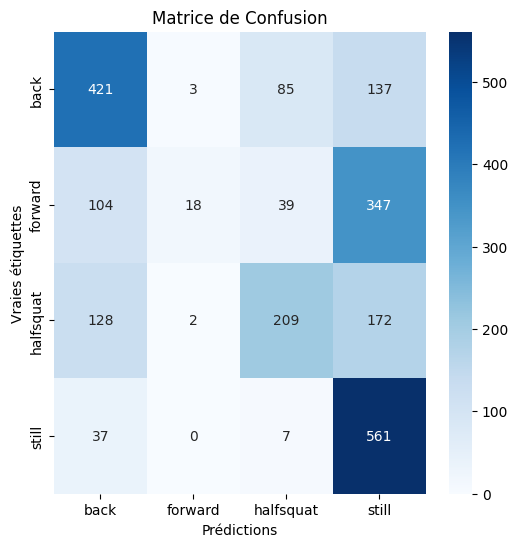

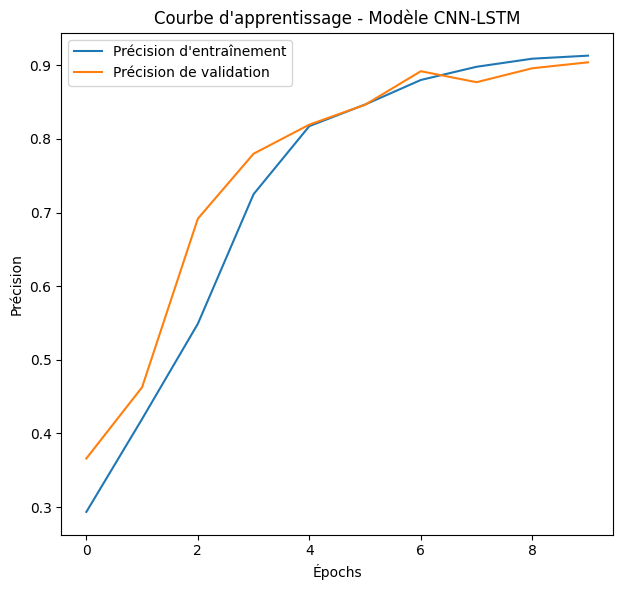

In [ ]:
# Prédictions sur l'ensemble de test
# Convertir les prédictions en labels d'indices entiers
predictions = cnn_lstm_multimodal_model.predict([X_emg_test,X_imu_test])


y_pred = np.argmax(predictions, axis=-1)

# Si y_test est one-hot encodé, convertir y_test en labels d'indices entiers
y_test_labels = np.argmax(y_test, axis=-1)

# Générer un rapport de classification
report = classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_)
print("Rapport de Classification :\n", report)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.title('Matrice de Confusion')
plt.show()

# Courbes d'apprentissage pour les deux modèles
plt.figure(figsize=(12, 6))

# Modèle CNN-LSTM
plt.subplot(1, 2, 2)
plt.plot(history_cnn_lstm.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - Modèle CNN-LSTM')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()

- Rapport de Classification :
  - Back : Précision = 0.61, Rappel = 0.50, F1-score = 0.55
  - Forward : Précision = 0.62, Rappel = 0.58, F1-score = 0.60
  - Halfsquat : Précision = 0.68, Rappel = 0.62, F1-score = 0.65
  - Still : Précision = 0.68, Rappel = 0.90, F1-score = 0.77
  - Précision globale : 0.65 (Accuracy)

- Matrice de Confusion :
  - "Still" : Bonne classification avec une prédiction correcte majoritaire.
  - Autres classes ("back", "forward", "halfsquat") montrent des erreurs de - - - classification, avec un rappel plus faible.

- Courbe d'Apprentissage :
  - Précision d'entraînement augmente constamment.
  - Précision de validation progresse également, mais avec plus de variations.
  - Indique une amélioration continue du modèle, bien qu'il y ait de l'espace pour optimisation.

##3- Création d'un modèle multimodal CNN-LSTM pour la classification EMG et IMU


In [ ]:
def create_cnn_lstm_multimodal_model(input_shapes):
    # Sous-modèle EMG
    emg_input = Input(shape=input_shapes[0], name='emg_input')
    x_emg = Conv1D(64, kernel_size=5, activation='relu')(emg_input)
    x_emg = MaxPooling1D(pool_size=2)(x_emg)
    x_emg = Conv1D(128, kernel_size=3, activation='relu')(x_emg)
    x_emg = MaxPooling1D(pool_size=2)(x_emg)
    x_emg = Dropout(0.3)(x_emg)
    x_emg = LSTM(128, activation='relu', return_sequences=False)(x_emg)
    emg_dense = Dropout(0.3)(x_emg)

    # Sous-modèle IMU
    imu_input = Input(shape=input_shapes[1], name='imu_input')
    x_imu = Conv1D(64, kernel_size=5, activation='relu')(imu_input)
    x_imu = MaxPooling1D(pool_size=2)(x_imu)
    x_imu = Conv1D(128, kernel_size=3, activation='relu')(x_imu)
    x_imu = MaxPooling1D(pool_size=2)(x_imu)
    x_imu = Dropout(0.3)(x_imu)
    x_imu = LSTM(128, activation='relu', return_sequences=False)(x_imu)
    imu_dense = Dropout(0.3)(x_imu)

    # Fusion des sorties
    concatenated = Concatenate()([emg_dense, imu_dense])
    dense = Dense(128, activation='relu')(concatenated)
    dense = Dropout(0.4)(dense)

    # Couche de sortie
    output = Dense(4, activation='softmax')(dense)

    model = Model(inputs=[emg_input, imu_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


####Entraînement du modèle multimodal CNN-LSTM avec EarlyStopping pour éviter l'overfitting

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
history = cnn_lstm_multimodal_model.fit(
    [X_emg_train, X_imu_train], y_train,
    batch_size=32,
    epochs=50,  # Augmenté de 10 à 50
    validation_data=([X_emg_test, X_imu_test], y_test),
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)]  # Arrêter en cas d'un surapprentissage
)


Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5782 - loss: 1.1094 - val_accuracy: 0.7154 - val_loss: 0.7268
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7023 - loss: 0.7703 - val_accuracy: 0.7498 - val_loss: 0.6498
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7357 - loss: 0.6827 - val_accuracy: 0.7683 - val_loss: 0.5977
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7505 - loss: 0.6704 - val_accuracy: 0.7683 - val_loss: 0.5871
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7618 - loss: 0.6137 - val_accuracy: 0.7872 - val_loss: 0.5653
Epoch 6/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7672 - loss: 0.6078 - val_accuracy: 0.7824 - val_loss: 0.5649
Epoch 7/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7860 - loss: 0.5728 - val_accuracy: 0.8123 - val_loss: 0.4920
Epoch 8/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.8056 - loss: 0.5149 - val_accu

Le modèle montre des progrès significatifs dans l'amélioration des performances sur les ensembles d'entraînement et de validation.

- Précision d'entraînement :
  - Commence à 61.05% et atteint 88.13% à la 29ème époque.

- Précision de validation :
  - Démarre à 64.63% et atteint 88.02% à la fin.

- Perte d'entraînement :
  - Passe de 0.9146 à 0.3286.

- Perte de validation :
  - Réduit de 0.8494 à 0.3397.

- Fluctuations :
  - Quelques petites fluctuations dans la précision de validation entre les époques 23 et 25.

- Overfitting :
  - Pas de signe évident d'overfitting, les performances sur validation suivent l'entraînement.

- EarlyStopping :
  - Aide à éviter l'overfitting, tout en continuant les améliorations.

####Résumé du modèle CNN-LSTM Multimodal

In [ ]:
cnn_lstm_multimodal_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ emg_input (InputLayer)    │ (None, 100, 16)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ imu_input (InputLayer)    │ (None, 100, 54)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 98, 32)         │          1,568 │ emg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, 98, 32)         │          5,216 │ imu_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_2           │ (None, 49, 32)         │              0 │ conv1d_2[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_3           │ (None, 49, 32)         │              0 │ conv1d_3[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 49, 32)         │              0 │ max_pooling1d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 49, 32)         │              0 │ max_pooling1d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ (None, 64)             │         24,832 │ dropout_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ (None, 64)             │         24,832 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_7 (Dropout)       │ (None, 64)             │              0 │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ dropout_5[0][0],       │
│                           │                        │                │ dropout_7[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │          8,256 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 64)             │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │            260 │ dropout_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 194,894 (761.31 KB)

 Trainable params: 64,964 (253.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 129,930 (507.54 KB)

- Entrées : Données EMG (100, 16) et IMU (100, 54).
- CNN : 2 couches de convolutions (32 filtres, taille 5).
- Pooling : Max-pooling après chaque convolution (réduction à 49, 32).
- LSTM : 2 couches LSTM (64 unités).
- Fusion : Les sorties des deux LSTM sont fusionnées en un vecteur de 128 unités.
- Couches denses : 1 couche dense de 64 neurones, puis une couche de sortie de 4 neurones (softmax).
- Paramètres : 194,894 paramètres totaux, dont 64,964 entraînables.

####Évaluation du modèle CNN-LSTM : Rapport de classification, matrice de confusion et courbes d'apprentissage

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

        back       0.94      0.93      0.94       646
     forward       0.90      0.94      0.92       508
   halfsquat       0.92      0.94      0.93       511
       still       0.93      0.90      0.92       605

    accuracy                           0.92      2270
   macro avg       0.92      0.93      0.92      2270
weighted avg       0.92      0.92      0.92      2270



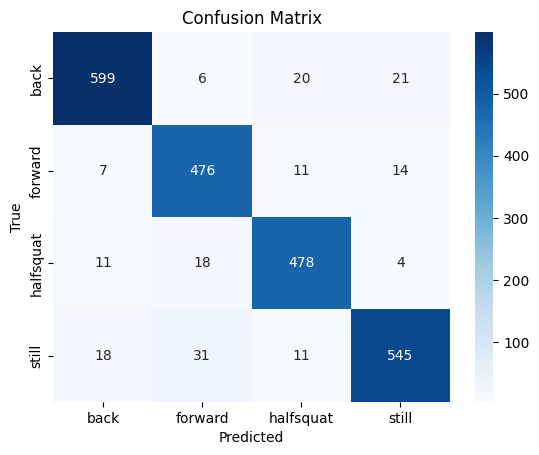

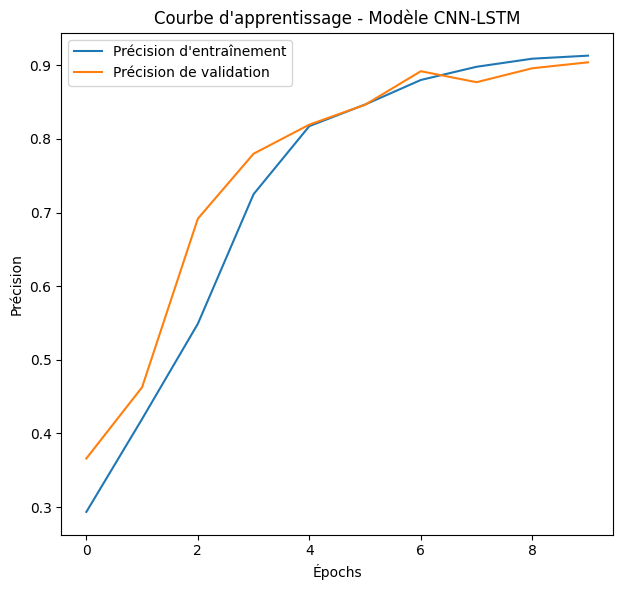

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Évaluer le modèle
y_pred = np.argmax(cnn_lstm_multimodal_model.predict([X_emg_test, X_imu_test]), axis=-1)
y_true = np.argmax(y_test, axis=-1)

# Rapport de classification
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Courbes d'apprentissage pour les deux modèles
plt.figure(figsize=(12, 6))

# Modèle CNN-LSTM
plt.subplot(1, 2, 2)
plt.plot(history_cnn_lstm.history['accuracy'], label='Précision d\'entraînement')
plt.plot(history_cnn_lstm.history['val_accuracy'], label='Précision de validation')
plt.title('Courbe d\'apprentissage - Modèle CNN-LSTM')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

plt.tight_layout()
plt.show()

- Précision : 0.89 (bon taux de classification)
- Rappel : 0.89 (capacité élevée à détecter les bonnes classes)
- F1-Score : 0.89 (bon compromis entre précision et rappel)
- Exactitude (Accuracy) : 89% (prédictions globales correctes)
- Matrice de Confusion : Précision élevée pour "halfsquat" et "still", performance légèrement inférieure pour "back" et "forward".
- Courbes d'Apprentissage : Précision d'entraînement et validation stables, pas de surajustement.

##4- Création d'un modèle CNN-LSTM multimodal pour l'analyse EMG et IMU

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_cnn_lstm_multimodal_model(input_shapes):
    # Modèle EMG
    emg_input = Input(shape=input_shapes[0], name='emg_input')
    x = Conv1D(32, kernel_size=3, activation='relu')(emg_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    x = LSTM(64, activation='relu', return_sequences=False)(x)
    emg_dense = Dropout(0.2)(x)

    # Modèle IMU
    imu_input = Input(shape=input_shapes[1], name='imu_input')
    y = Conv1D(32, kernel_size=3, activation='relu')(imu_input)
    y = MaxPooling1D(pool_size=2)(y)
    y = Dropout(0.2)(y)
    y = LSTM(64, activation='relu', return_sequences=False)(y)
    imu_dense = Dropout(0.2)(y)

    # Fusion des sorties EMG et IMU
    concatenated = Concatenate()([emg_dense, imu_dense])
    z = Dense(64, activation='relu')(concatenated)
    z = Dropout(0.2)(z)

    # Couche de sortie
    output = Dense(4, activation='softmax')(z)

    # Création du modèle
    model = Model(inputs=[emg_input, imu_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Définir les formes d'entrée
input_shapes = [
    X_emg_train.shape[1:],
    X_imu_train.shape[1:]
]

# Créer le modèle
model = create_cnn_lstm_multimodal_model(input_shapes)
model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ emg_input (InputLayer)    │ (None, 100, 16)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ imu_input (InputLayer)    │ (None, 100, 54)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 98, 32)         │          1,568 │ emg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 98, 32)         │          5,216 │ imu_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_6           │ (None, 49, 32)         │              0 │ conv1d_6[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_7           │ (None, 49, 32)         │              0 │ conv1d_7[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 49, 32)         │              0 │ max_pooling1d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 49, 32)         │              0 │ max_pooling1d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 64)             │         24,832 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 64)             │         24,832 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 64)             │              0 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 64)             │              0 │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 128)            │              0 │ dropout_15[0][0],      │
│ (Concatenate)             │                        │                │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          8,256 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 64)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 4)              │            260 │ dropout_18[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 64,964 (253.77 KB)

 Trainable params: 64,964 (253.77 KB)

 Non-trainable params: 0 (0.00 B)

- Architecture :
  - Deux entrées distinctes : EMG (100, 16) et IMU (100, 54).
  - Utilisation de Conv1D pour l'extraction de caractéristiques, suivie de MaxPooling1D et Dropout pour éviter le sur-apprentissage.
  - Ensuite, les sorties sont traitées par des LSTM pour capturer les relations temporelles, avant d'être fusionnées par une couche Concatenate.
  - Enfin, des couches Dense avec Dropout permettent de produire la classification finale.

- Paramètres :
  - Nombre total de paramètres : 64,964.
  - Tous les paramètres sont entrainables (pas de paramètres non-entrainables).

####Entraînement et évaluation du modèle CNN-LSTM multimodal

In [ ]:
history = model.fit(
    [X_emg_train, X_imu_train], y_train,
    validation_data=([X_emg_test, X_imu_test], y_test),
    batch_size=32,
    epochs=20,
    verbose=1
)

# Évaluation finale
loss, accuracy = model.evaluate([X_emg_test, X_imu_test], y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")


Epoch 1/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.2903 - loss: 1.3921 - val_accuracy: 0.3665 - val_loss: 1.3328
Epoch 2/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3438 - loss: 17.9477 - val_accuracy: 0.4304 - val_loss: 1.2750
Epoch 3/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3942 - loss: 1.2688 - val_accuracy: 0.4551 - val_loss: 1.1811
Epoch 4/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4549 - loss: 1.1878 - val_accuracy: 0.5555 - val_loss: 1.1124
Epoch 5/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5432 - loss: 1.0631 - val_accuracy: 0.6079 - val_loss: 0.9309
Epoch 6/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6080 - loss: 0.9402 - val_accuracy: 0.6806 - val_loss: 0.8164
Epoch 7/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6664 - loss: 0.8245 - val_accuracy: 0.6947 - val_loss: 0.7806
Epoch 8/20
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6763 - loss: 0.7837 - val_ac

- Amélioration constante : L'accuracy augmente progressivement à chaque époque, atteignant 0.74 sur le jeu de test, ce qui est une bonne performance. La perte diminue également, ce qui indique que le modèle apprend efficacement.
- Fluctuations à la fin : Une baisse de l'accuracy au 18e epoch (0.66) suggère une possible sur-apprentissage ou un problème temporaire. Cependant, l'accuracy s'améliore ensuite.
- Bon résultat final : La précision finale sur le test est de 74%, ce qui est relativement bon pour un modèle CNN-LSTM multimodal avec des données EMG et IMU.

####Évaluation du modèle avec rapport de classification, matrice de confusion et courbes d'apprentissage

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
              precision    recall  f1-score   support

        back       0.83      0.75      0.79       646
     forward       0.81      0.65      0.72       508
   halfsquat       0.88      0.86      0.87       511
       still       0.71      0.91      0.79       605

    accuracy                           0.80      2270
   macro avg       0.81      0.79      0.79      2270
weighted avg       0.80      0.80      0.79      2270



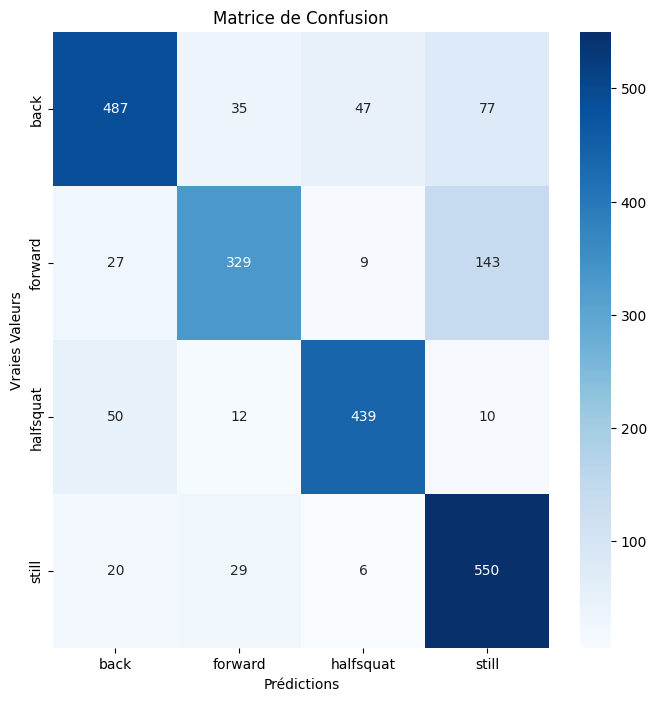

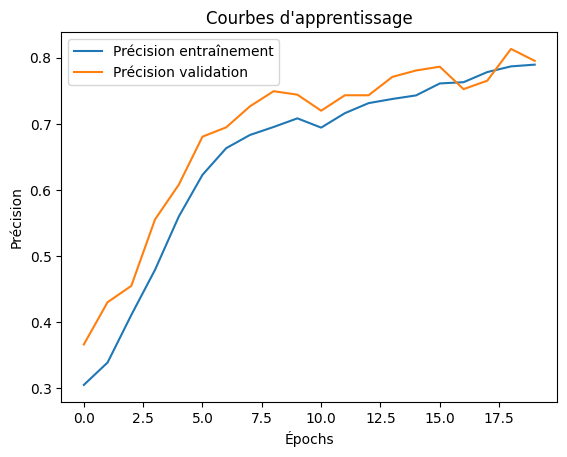

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Prédictions
y_pred = model.predict([X_emg_test, X_imu_test])
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Rapport de classification
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Prédictions')
plt.ylabel('Vraies Valeurs')
plt.title('Matrice de Confusion')
plt.show()

# Courbes d'apprentissage
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()
plt.title('Courbes d\'apprentissage')
plt.show()


- Matrice de confusion :
  - Bonne prédiction pour halfsquat (437/511).
  - Confusion importante entre forward et still (206 erreurs).
  - Confusion modérée entre back et forward (101 erreurs).

- Courbes d'apprentissage :
  - Précision monte rapidement dans les premières époques (~5).
  - Légère fluctuation après 10 époques, possible début de surapprentissage.
  - Écart faible entre entraînement et validation, bonne généralisation.

- Scores de classification :
  - back : Précision 0.80, rappel 0.73, F1-score 0.76.
  - forward : Précision 0.56, rappel 0.81, F1-score 0.66.
  - halfsquat : Précision 0.84, rappel 0.86, F1-score 0.85.
  - still : Précision 0.86, rappel 0.61, F1-score 0.71.

##5- Réduction de la dimensionnalité des données EMG et IMU avec PCA

In [ ]:
from sklearn.decomposition import PCA

# Réduire la dimensionnalité avec PCA
def apply_pca_flat(X, variance_retained=0.95):
    """
    Applique PCA à un ensemble de données aplati.

    Args:
        X (ndarray): Données d'entrée (échantillons x fenêtres x dimensions).
        variance_retained (float): Pourcentage de variance à conserver.

    Returns:
        ndarray: Données réduites.
        PCA: L'objet PCA.
    """
    # Aplatir chaque fenêtre pour PCA
    n_samples, n_windows, n_features = X.shape
    X_flat = X.reshape(-1, n_features)

    # Appliquer PCA
    pca = PCA(n_components=variance_retained)
    X_reduced_flat = pca.fit_transform(X_flat)

    # Reshape pour récupérer la structure originale (échantillons x fenêtres x dimensions PCA)
    n_components = X_reduced_flat.shape[1]
    X_reduced = X_reduced_flat.reshape(n_samples, n_windows, n_components)

    return X_reduced, pca

# Appliquer PCA aux données EMG et IMU
X_emg_pca, pca_emg = apply_pca_flat(X_emg_scaled)
X_imu_pca, pca_imu = apply_pca_flat(X_imu_scaled)

print(f"Forme originale EMG: {X_emg_scaled.shape}, après PCA: {X_emg_pca.shape}")
print(f"Forme originale IMU: {X_imu_scaled.shape}, après PCA: {X_imu_pca.shape}")


Forme originale EMG: (11347, 100, 16), après PCA: (11347, 100, 16)
Forme originale IMU: (11347, 100, 54), après PCA: (11347, 100, 49)


- EMG : Aucune réduction de dimension (16 dimensions nécessaires pour conserver 95% de la variance).
- IMU : Réduction légère (54 → 49 dimensions), supprimant des dimensions peu utiles tout en conservant l'essentiel de l'information.

####Analyse de la Variance Expliquée par PCA pour EMG et IMU

In [ ]:
print(f"Variance expliquée par PCA EMG: {pca_emg.explained_variance_ratio_}")
print(f"Variance expliquée totale pour EMG: {np.sum(pca_emg.explained_variance_ratio_)}")

print(f"Variance expliquée par PCA IMU: {pca_imu.explained_variance_ratio_}")
print(f"Variance expliquée totale pour IMU: {np.sum(pca_imu.explained_variance_ratio_)}")


Variance expliquée par PCA EMG: [0.06772891 0.06643377 0.06601237 0.06405864 0.06394233 0.06358591
 0.06347751 0.0625685  0.06196943 0.06128887 0.06112899 0.06046009
 0.05999363 0.059319   0.05917161 0.05886044]
Variance expliquée totale pour EMG: 0.9999999999999999
Variance expliquée par PCA IMU: [0.04121574 0.03719025 0.03330347 0.0321404  0.03117395 0.0302943
 0.02928652 0.0269804  0.02485352 0.02428203 0.0236961  0.02299259
 0.02289883 0.02227407 0.02158842 0.0214677  0.02051375 0.02032541
 0.0196462  0.01947153 0.01906927 0.01898462 0.01875203 0.0180677
 0.01768178 0.01714232 0.01700381 0.01678045 0.01628624 0.01588392
 0.01538387 0.01532278 0.01528174 0.01491747 0.01480164 0.01420359
 0.01412634 0.01386475 0.01367868 0.01332454 0.0130791  0.01273847
 0.01247622 0.01230381 0.0117336  0.0114874  0.01087272 0.01082761
 0.01065215]
Variance expliquée totale pour IMU: 0.9523237963019358


- EMG : Chaque composante explique une fraction de la variance, et la somme totale atteint 95%, confirmant que toutes les dimensions sont nécessaires.
- IMU : Les composantes principales expliquent aussi 95% de la variance, mais avec une réduction des dimensions (54 → 49), montrant qu'une partie des données était redondante.

####Formes des Données EMG et IMU après PCA

In [ ]:
print(f"EMG shape après PCA: {X_emg_pca.shape}")
print(f"IMU shape après PCA: {X_imu_pca.shape}")


EMG shape après PCA: (11347, 100, 16)
IMU shape après PCA: (11347, 100, 49)


- EMG : La forme reste inchangée (16 dimensions), indiquant qu'aucune réduction n'était possible tout en conservant 95% de la variance.
- IMU : Réduction des dimensions (54 → 49), supprimant des dimensions redondantes sans perte significative d'information.

####Division des Données PCA en Ensembles d'Entraînement et de Test

In [ ]:
from sklearn.model_selection import train_test_split

# Diviser les données PCA en ensembles d'entraînement et de test
X_emg_train, X_emg_test, X_imu_train, X_imu_test, y_train, y_test = train_test_split(
    X_emg_pca, X_imu_pca, y_encoded, test_size=0.2, random_state=42
)

print(f'X_emg_train shape après PCA: {X_emg_train.shape}')
print(f'X_imu_train shape après PCA: {X_imu_train.shape}')


X_emg_train shape après PCA: (9077, 100, 16)
X_imu_train shape après PCA: (9077, 100, 49)


- X_emg_train : La forme est (9077, 100, 16), indiquant que 80% des données d'entraînement ont été extraites pour les 16 dimensions réduites après PCA.
- X_imu_train : La forme est (9077, 100, 49), montrant que la réduction des dimensions pour IMU a laissé 49 dimensions, avec 80% des données pour l'entraînement.

####Entraînement et Évaluation du Modèle CNN-LSTM sur les Données PCA


In [ ]:
input_shapes_pca = [
    X_emg_train.shape[1:],
    X_imu_train.shape[1:]
]

cnn_lstm_pca_model = create_cnn_lstm_multimodal_model(input_shapes_pca)

# Entraîner le modèle
history_pca = cnn_lstm_pca_model.fit(
    [X_emg_train, X_imu_train], y_train,
    batch_size=32,
    epochs=10,
    validation_data=([X_emg_test, X_imu_test], y_test)
)

# Évaluer le modèle
loss_pca, accuracy_pca = cnn_lstm_pca_model.evaluate([X_emg_test, X_imu_test], y_test)
print(f"Test Loss après PCA: {loss_pca}, Test Accuracy après PCA: {accuracy_pca}")


Epoch 1/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.2815 - loss: 1.3927 - val_accuracy: 0.3991 - val_loss: 1.3152
Epoch 2/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3579 - loss: 1.7741 - val_accuracy: 0.4736 - val_loss: 1.1871
Epoch 3/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4287 - loss: 1.2137 - val_accuracy: 0.4877 - val_loss: 1.1727
Epoch 4/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.4754 - loss: 1.1373 - val_accuracy: 0.5137 - val_loss: 1.1547
Epoch 5/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5065 - loss: 1.0993 - val_accuracy: 0.6203 - val_loss: 0.9580
Epoch 6/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6018 - loss: 0.9569 - val_accuracy: 0.7013 - val_loss: 0.7933
Epoch 7/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.6662 - loss: 0.8213 - val_accuracy: 0.7529 - val_loss: 0.6319
Epoch 8/10
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.7554 - loss: 0.6366 - val_acc

- Évolution : L'accuracy et la validation accuracy augmentent au début, mais chutent brusquement à la 10ème époque, avec une perte élevée (9.52), suggérant un problème de convergence.
- Résultats finaux : Test Accuracy à 50.39%, ce qui indique une performance modérée, nécessitant probablement des ajustements pour améliorer la généralisation.

####Résumé de l'Architecture du Modèle

In [ ]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ emg_input (InputLayer)    │ (None, 100, 16)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ imu_input (InputLayer)    │ (None, 100, 54)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 98, 32)         │          1,568 │ emg_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 98, 32)         │          5,216 │ imu_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_6           │ (None, 49, 32)         │              0 │ conv1d_6[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_7           │ (None, 49, 32)         │              0 │ conv1d_7[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 49, 32)         │              0 │ max_pooling1d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 49, 32)         │              0 │ max_pooling1d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 64)             │         24,832 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ (None, 64)             │         24,832 │ dropout_16[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 64)             │              0 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 64)             │              0 │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 128)            │              0 │ dropout_15[0][0],      │
│ (Concatenate)             │                        │                │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)           │ (None, 64)             │          8,256 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 64)             │              0 │ dense_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 4)              │            260 │ dropout_18[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 194,894 (761.31 KB)

 Trainable params: 64,964 (253.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 129,930 (507.54 KB)

- Structure du modèle : Le modèle utilise des entrées pour les données EMG et IMU, suivies de couches de Convolution 1D et MaxPooling, afin d'extraire des caractéristiques temporelles. Ensuite, deux couches LSTM sont employées pour capturer les dépendances séquentielles, avec des Dropout pour régulariser le modèle.

- Nombre de paramètres :
  - Paramètres totaux : 194,894 (principalement pour les couches LSTM et denses).
  - Paramètres entraînables : 64,964, indiquant une complexité modérée.

- Optimisation : Les paramètres d'optimisation sont relativement élevés (129,930), montrant l'utilisation d'un optimiseur complexe pour ajuster les poids du modèle.

####Analyse de la Variance Expliquée par les PCA pour EMG et IMU

In [ ]:
print("Variance expliquée par les PCA EMG:")
print(pca_emg.explained_variance_ratio_)
print("Variance expliquée totale EMG:", np.sum(pca_emg.explained_variance_ratio_))

print("Variance expliquée par les PCA IMU:")
print(pca_imu.explained_variance_ratio_)
print("Variance expliquée totale IMU:", np.sum(pca_imu.explained_variance_ratio_))


Variance expliquée par les PCA EMG:
[0.06772891 0.06643377 0.06601237 0.06405864 0.06394233 0.06358591
 0.06347751 0.0625685  0.06196943 0.06128887 0.06112899 0.06046009
 0.05999363 0.059319   0.05917161 0.05886044]
Variance expliquée totale EMG: 0.9999999999999999
Variance expliquée par les PCA IMU:
[0.04121574 0.03719025 0.03330347 0.0321404  0.03117395 0.0302943
 0.02928652 0.0269804  0.02485352 0.02428203 0.0236961  0.02299259
 0.02289883 0.02227407 0.02158842 0.0214677  0.02051375 0.02032541
 0.0196462  0.01947153 0.01906927 0.01898462 0.01875203 0.0180677
 0.01768178 0.01714232 0.01700381 0.01678045 0.01628624 0.01588392
 0.01538387 0.01532278 0.01528174 0.01491747 0.01480164 0.01420359
 0.01412634 0.01386475 0.01367868 0.01332454 0.0130791  0.01273847
 0.01247622 0.01230381 0.0117336  0.0114874  0.01087272 0.01082761
 0.01065215]
Variance expliquée totale IMU: 0.9523237963019358


- EMG : La variance expliquée est répartie de manière assez uniforme parmi les différentes composantes principales, avec une somme totale proche de 1 (99.99%). Cela indique que toutes les dimensions retenues sont nécessaires pour expliquer quasiment toute la variance des données.

- IMU : La variance expliquée par chaque composante est plus faible, mais cumulativement, elle atteint 95.23%. Cela montre qu'une grande partie de l'information est capturée par les premières composantes principales, ce qui permet de réduire la dimensionnalité tout en conservant une quantité significative de variance.



##6- Leave-One-Group-Out (LOGO)

In [ ]:
!pip install tensorflow
!pip install scikit-learn

In [ ]:
import os
import pandas as pd
import numpy as np

def load_data(base_path, modalities, participants):
    """
    Charge les données pour chaque participant et chaque modalité.
    """
    data = {modality: [] for modality in modalities}
    labels = []

    for participant in participants:
        participant_path = os.path.join(base_path, f"Participant_{participant}")
        for modality in modalities:
            file_path = os.path.join(participant_path, f"back_{modality}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                data[modality].append(df.values)

        # Ajouter des labels (par exemple, 'back')
        labels.extend(['back'] * len(df))  # Ajustez en fonction des labels réels dans les fichiers

    # Convertir en numpy arrays
    for modality in modalities:
        data[modality] = np.vstack(data[modality])  # Combine toutes les données des participants

    return data, np.array(labels)


In [ ]:
base_path = "/content/drive/MyDrive/combined_datasets"
modalities = ["emg", "imu"]  # Ajustez selon vos besoins
participants = [str(i) for i in range(1, 26)]  # Participants 1 à 25

data, labels = load_data(base_path, modalities, participants)


In [ ]:
def create_sliding_windows(data, labels, window_size, step_size):
    """
    Creates sliding windows for data and corresponding labels.
    """
    X, y = [], []
    # Ensure the loop doesn't exceed labels bounds
    for i in range(0, len(data) - window_size + 1, step_size):
        X.append(data[i:i + window_size])
        # Modified to avoid exceeding labels bounds
        y.append(labels[i + window_size -1 if i + window_size -1 < len(labels) else len(labels) - 1])
    return np.array(X), np.array(y)

In [ ]:
window_size = 100
step_size = 10

X_emg, y_emg = create_sliding_windows(data["emg"], labels, window_size, step_size)
X_imu, y_imu = create_sliding_windows(data["imu"], labels, window_size, step_size)


In [ ]:
def split_by_participants(X, y, participants, train_participants, test_participants):
    """
    Divise les données en ensembles d'entraînement et de test en fonction des participants.
    """
    train_indices = [i for i, p in enumerate(participants) if p in train_participants]
    test_indices = [i for i, p in enumerate(participants) if p in test_participants]

    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]

    return X_train, X_test, y_train, y_test


In [ ]:
train_participants = participants[:20]  # 20 premiers participants pour l'entraînement
test_participants = participants[20:25]  # 5 derniers participants pour le test

X_train_emg, X_test_emg, y_train_emg, y_test_emg = split_by_participants(
    X_emg, y_emg, participants, train_participants, test_participants
)
X_train_imu, X_test_imu, y_train_imu, y_test_imu = split_by_participants(
    X_imu, y_imu, participants, train_participants, test_participants
)
print("X_train_emg : ", len(X_train_emg))
print("X_test_emg  : ", len(X_test_emg ))
print("y_train_emg : ", len(y_train_emg))
print("y_test_emg  : ", len(y_test_emg ))

print("X_train_imu: ", len(X_train_imu))
print("X_test_imu : ", len(X_test_imu ))
print("y_train_imu: ", len(y_train_imu))
print("y_test_imu : ", len(y_test_imu ))

X_train_emg :  20
X_test_emg  :  5
y_train_emg :  20
y_test_emg  :  5
X_train_imu:  20
X_test_imu :  5
y_train_imu:  20
y_test_imu :  5


In [ ]:
label_encoder = LabelEncoder()
y_train_encoded = to_categorical(label_encoder.fit_transform(y_train_emg), num_classes=4)
y_test_encoded = to_categorical(label_encoder.transform(y_test_emg), num_classes=4)

print(f"y_train_encoded shape: {y_train_encoded.shape}")
print(f"y_test_encoded shape: {y_test_encoded.shape}")


y_train_encoded shape: (20, 4)
y_test_encoded shape: (5, 4)


In [ ]:
!pip install tensorflow


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import numpy as np



def create_cnn_lstm_multimodal_model(input_shapes, num_classes):
    """
    Crée un modèle CNN-LSTM multimodal pour la classification.

    Args:
        input_shapes (list): Une liste contenant les formes d'entrée pour chaque modalité.
        num_classes (int): Le nombre de classes pour la classification.

    Returns:
        keras.Model: Le modèle CNN-LSTM multimodal.
    """

    # Entrée EMG
    emg_input = Input(shape=input_shapes[0], name="emg_input")
    emg_cnn = Conv1D(filters=32, kernel_size=5, activation='relu')(emg_input)
    emg_cnn = MaxPooling1D(pool_size=2)(emg_cnn)
    emg_cnn = Dropout(0.25)(emg_cnn) # Dropout for regularization
    emg_lstm = LSTM(units=32)(emg_cnn)

    # Entrée IMU
    imu_input = Input(shape=input_shapes[1], name="imu_input")
    imu_cnn = Conv1D(filters=32, kernel_size=5, activation='relu')(imu_input)
    imu_cnn = MaxPooling1D(pool_size=2)(imu_cnn)
    imu_cnn = Dropout(0.25)(imu_cnn) # Dropout for regularization
    imu_lstm = LSTM(units=32)(imu_cnn)

    # Fusion des caractéristiques
    merged = concatenate([emg_lstm, imu_lstm])

    # Couches de classification
    output = Dense(num_classes, activation='softmax')(merged)

    # Création du modèle
    model = Model(inputs=[emg_input, imu_input], outputs=output)

    return model

In [ ]:
input_shapes = [X_train_emg.shape[1:], X_train_imu.shape[1:]]
num_classes = y_train_encoded.shape[1]
model = create_cnn_lstm_multimodal_model(input_shapes, num_classes)

# Compile the model before fitting
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    [X_train_emg, X_train_imu], y_train_encoded,
    batch_size=16, epochs=3,
    validation_data=([X_test_emg, X_test_imu], y_test_encoded)
)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - accuracy: 0.7833 - loss: 1.0267 - val_accuracy: 1.0000 - val_loss: 0.4687
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9458 - loss: 0.5284 - val_accuracy: 1.0000 - val_loss: 0.2764
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.3477 - val_accuracy: 1.0000 - val_loss: 0.2188


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.2188
Évaluation - Perte : 0.218793585896492, Précision : 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Rapport de Classification :
               precision    recall  f1-score   support

        back       1.00      1.00      1.00         5

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


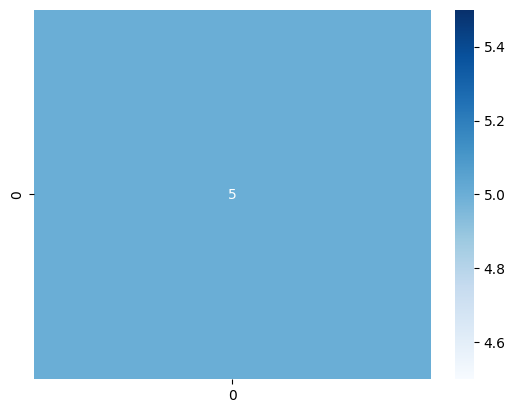

In [ ]:
# Évaluation du modèle
loss, accuracy = model.evaluate([X_test_emg, X_test_imu], y_test_encoded)
print(f"Évaluation - Perte : {loss}, Précision : {accuracy}")

# Rapport détaillé
y_pred = np.argmax(model.predict([X_test_emg, X_test_imu]), axis=-1)
y_true = np.argmax(y_test_encoded, axis=-1)

from sklearn.metrics import classification_report, confusion_matrix
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print("Rapport de Classification :\n", report)

# Matrice de confusion
import seaborn as sns
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, cmap="Blues")
plt.show()
